In [5]:
# @title Imports & Settings
# This cell prepares a clean, minimal environment used throughout the project.

# 1) Quiet mode: hide non‑critical warnings so outputs stay readable.
import warnings
warnings.filterwarnings("ignore")

# 2) Core numerics & tables:
import numpy as np            # fast math on arrays (used in metrics/simulations)
import pandas as pd           # time‑series tables (DataFrame) and date handling

# 3) Econometrics (kept minimal; add more only when needed):
import statsmodels.api as sm  # regressions + HAC robust errors

# 4) Data access: pull FRED series via pandas‑datareader when we fetch data.
from pandas_datareader import data as web

# 5) Reproducibility: set a single random seed for any stochastic steps (e.g., simulations).
np.random.seed(42)

# 6) Pretty tables: make DataFrame printing easier to read in Colab.
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 20)

In [6]:
# @title Acquire Data (monthly, aligned to month‑end) — with NASDAQ Composite
# Purpose: Pull required FRED series, align to MONTH‑END, assemble one table "raw", and show missingness.
# Notes:
# - Replaces equity proxy with NASDAQ Composite (NASDAQCOM) for risk‑sensitive market sentiment.
# - Uses fallback for IG yield tickers; skips a series if no ticker works (logged).
# - We only FETCH here; cleaning/interpolation happens in the next step.

import pandas as pd
from pandas_datareader import data as web

# 0) Dates (use cfg if previously defined; else defaults so this cell runs standalone)
try:
    START, END = cfg.start, cfg.end                    # from your config cell (if present)
except NameError:
    START, END = "1996-01-01", "2024-12-31"            # fallback defaults

# 1) Series map: FRED tickers (with fallbacks where needed)
SERIES = {
    # Policy & targets
    "fed_funds":        ["FEDFUNDS"],
    "fed_target_upper": ["DFEDTARU"],
    "fed_target_lower": ["DFEDTARL"],
    # Treasury curve
    "t3m":  ["TB3MS"],
    "y2":   ["GS2"],
    "y10":  ["GS10"],
    "y30":  ["GS30"],
    # Prices & activity
    "cpi":               ["CPIAUCSL"],
    "core_cpi":          ["CPILFESL"],
    "pcepi":             ["PCEPI"],
    "indpro":            ["INDPRO"],
    "unemployment_rate": ["UNRATE"],
    "nonfarm_payrolls":  ["PAYEMS"],
    "m2":                ["M2SL"],
    # Markets (daily → monthly)
    "nasdaq": ["NASDAQCOM"],
    "vix":    ["VIXCLS"],
    # Corporate yields
    "hy_yield": ["BAMLH0A0HYM2EY"],
    "ig_yield": ["BAMLC0A0CMEY", "BAMLC0A0CM"],  # fallback ticker
    # Benchmarks
    "aaa_yield": ["AAA"],
    "baa_yield": ["BAA"],
    # Recession indicator
    "recession": ["USREC"],
}

# 2) Helper: load one FRED series and resample to month‑end
def _fetch(series_id: str, start: str, end: str, name: str) -> pd.DataFrame:
    s = web.DataReader(series_id, "fred", start, end).squeeze()  # get as Series
    s = s.resample("M").last()                                   # align to month‑end
    s.name = name                                                # column name = friendly key
    return s.to_frame()

# 3) Try each fallback until one works; skip if none do (log a warning)
def fetch_with_fallback(ids, name, start, end):
    for sid in ids:
        try:
            df_part = _fetch(sid, start, end, name)
            print(f"✓ {name}  ←  {sid}")                         # success log
            return df_part
        except Exception as e:
            print(f"… failed {sid} for {name}: {e}")             # failure log
    print(f"⚠ Skipping {name}: no ticker worked.")               # final warning
    return None

# 4) Loop all series, merge to one DataFrame
frames = []
for colname, ids in SERIES.items():
    part = fetch_with_fallback(ids, colname, START, END)
    if part is not None:
        frames.append(part)

raw = pd.concat(frames, axis=1).sort_index().loc[START:END]
raw.index.name = "DATE"                                          # standardize index name

# 5) Quick diagnostics: shape, time span, and top missing series
print("\nRaw shape:", raw.shape)
print("Date range:", raw.index.min().date(), "→", raw.index.max().date())

missing = raw.isna().sum().sort_values(ascending=False)
print("\nTop missing counts:")
display(missing.head(15))

# 6) Preview first rows so the team sees structure
display(raw.head(3))


✓ fed_funds  ←  FEDFUNDS
✓ fed_target_upper  ←  DFEDTARU
✓ fed_target_lower  ←  DFEDTARL
✓ t3m  ←  TB3MS
✓ y2  ←  GS2
✓ y10  ←  GS10
✓ y30  ←  GS30
✓ cpi  ←  CPIAUCSL
✓ core_cpi  ←  CPILFESL
✓ pcepi  ←  PCEPI
✓ indpro  ←  INDPRO
✓ unemployment_rate  ←  UNRATE
✓ nonfarm_payrolls  ←  PAYEMS
✓ m2  ←  M2SL
✓ nasdaq  ←  NASDAQCOM
✓ vix  ←  VIXCLS
✓ hy_yield  ←  BAMLH0A0HYM2EY
✓ ig_yield  ←  BAMLC0A0CMEY
✓ aaa_yield  ←  AAA
✓ baa_yield  ←  BAA
✓ recession  ←  USREC

Raw shape: (348, 21)
Date range: 1996-01-31 → 2024-12-31

Top missing counts:


fed_target_upper     155
fed_target_lower     155
ig_yield              11
hy_yield              11
fed_funds              0
y2                     0
t3m                    0
y10                    0
y30                    0
pcepi                  0
indpro                 0
cpi                    0
core_cpi               0
nonfarm_payrolls       0
unemployment_rate      0
dtype: int64

,fed_funds,fed_target_upper,fed_target_lower,t3m,y2,y10,y30,cpi,core_cpi,pcepi,...,unemployment_rate,nonfarm_payrolls,m2,nasdaq,vix,hy_yield,ig_yield,aaa_yield,baa_yield,recession
DATE,,,,,,,,,,,,,,,,,,,,,
1996-01-31,5.56,NaN,NaN,5.00,5.11,5.65,6.05,154.7,163.7,68.452,...,5.6,118317,3647.9,1059.79,12.53,NaN,NaN,6.81,7.47,0
1996-02-29,5.22,NaN,NaN,4.83,5.03,5.81,6.24,155.0,164.0,68.560,...,5.5,118737,3661.8,1100.05,17.04,NaN,NaN,6.99,7.63,0
1996-03-31,5.31,NaN,NaN,4.96,5.66,6.27,6.60,155.5,164.4,68.767,...,5.5,118992,3686.9,1101.40,18.88,NaN,NaN,7.35,8.03,0


In [8]:
# @title Clean & Interpolate (no forward-fill)
# Purpose: Turn RAW monthly series into a clean table for modeling.
# Method: type coercion → de-duplicate → monthly grid → time-based interpolation (no ffill).
# Notes:
# - We DO NOT forward-fill. We use time-aware interpolation (and linear at edges) for numeric series.
# - We KEEP structural NaNs (e.g., Fed target bounds pre-2008); we do NOT fabricate data there.

import pandas as pd
import numpy as np

# 0) Start from raw (created in the previous step)
df = raw.copy()

# 1) Ensure DatetimeIndex (month-end), sorted, unique
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df = df[~df.index.duplicated(keep="last")]

# 2) Reindex to a complete month-end grid (prevents hidden gaps)
m_end = pd.date_range(df.index.min().to_period("M").to_timestamp("M"),
                      df.index.max().to_period("M").to_timestamp("M"),
                      freq="M")
df = df.reindex(m_end)
df.index.name = "DATE"

# 3) Coerce to numeric for safety (non-parsable → NaN)
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# 4) Interpolate numeric market/macro series (NO forward-fill)
#    - Exclude series we do not want to fabricate historically (Fed target bounds, recession flag).
exclude = {"fed_target_upper", "fed_target_lower", "recession"}
interp_cols = [c for c in df.columns if c not in exclude]

for c in interp_cols:
    # time-aware interpolation inside the sample; linear handles edge NaNs without ffill/bfill semantics
    # (uses neighboring slope rather than copying last value)
    try:
        df[c] = df[c].interpolate(method="time", limit_direction="both")
    except Exception:
        df[c] = df[c].interpolate(method="linear", limit_direction="both")

# 5) Light sanity constraints (clips only impossible values; adjust if needed)
lower_bounds = {
    "vix": 0.0,          # VIX cannot be negative
    "hy_yield": 0.0,     # yields below 0 are implausible in USD HY history
    "ig_yield": 0.0,
}
for c, lb in lower_bounds.items():
    if c in df.columns:
        df[c] = df[c].clip(lower=lb)

# 6) Post-clean diagnostics (confirm NaNs only where expected)
missing_after = df.isna().sum().sort_values(ascending=False)

print("Clean complete")
print(f"Span: {df.index.min().date()} → {df.index.max().date()} | Rows: {len(df)} | Cols: {df.shape[1]}")
print("\nTop missing counts (after clean):")
display(missing_after.head(10))

# 7) Hand off: this 'df' is the CLEANED dataset to use for Feature Engineering.


Clean complete
Span: 1996-01-31 → 2024-12-31 | Rows: 348 | Cols: 21

Top missing counts (after clean):


fed_target_upper    155
fed_target_lower    155
fed_funds             0
t3m                   0
y2                    0
y10                   0
y30                   0
cpi                   0
core_cpi              0
pcepi                 0
dtype: int64

In [9]:
# @title Core Targets: Credit Spread & Changes

# --- Feature Engineering Step 1 ---
# Build the main dependent variables (targets) for analysis:
#   1. Credit Spread = HY yield - IG yield
#   2. ΔHY Yield = monthly change in HY yield
#   3. ΔCredit Spread = monthly change in Credit Spread
#
# Why?
# - Credit spread shows the risk premium in high-yield vs safer bonds.
# - Changes (Δ) are used instead of levels to ensure stationarity
#   and to focus on dynamics rather than long-term drift.

df = raw.copy()

# Credit Spread
df["credit_spread"] = df["hy_yield"] - df["ig_yield"]

# Changes (month-over-month)
df["d_hy_yield"] = df["hy_yield"].diff()
df["d_credit_spread"] = df["credit_spread"].diff()

# Quick check
print(df[["hy_yield", "ig_yield", "credit_spread", "d_hy_yield", "d_credit_spread"]].head(6))


            hy_yield  ig_yield  credit_spread  d_hy_yield  d_credit_spread
DATE                                                                      
1996-01-31       NaN       NaN            NaN         NaN              NaN
1996-02-29       NaN       NaN            NaN         NaN              NaN
1996-03-31       NaN       NaN            NaN         NaN              NaN
1996-04-30       NaN       NaN            NaN         NaN              NaN
1996-05-31       NaN       NaN            NaN         NaN              NaN
1996-06-30       NaN       NaN            NaN         NaN              NaN


In [10]:
# @title Feature Group: Monetary Policy Drivers (ΔFed Funds & Target Range)
# Goal: Create policy variables that capture the stance/moves of the Federal Reserve.
# Why:
# - d_fed_funds: monthly change in the policy rate → direct tightening/loosening signal.
# - target_range: width between target upper/lower bounds → useful during regimes with explicit ranges (post-2008).
# Inputs assumed present (from cleaned data): 'fed_funds', 'fed_target_upper', 'fed_target_lower'
# Output: adds 'd_fed_funds' and 'target_range' to df

# Safety: ensure we're working off the cleaned table
df = df.copy()

# 1) Monthly change in Fed Funds (Δ)
df["d_fed_funds"] = df["fed_funds"].diff()

# 2) Policy target range width (upper − lower); keep NaN where bounds didn’t exist historically
df["target_range"] = df["fed_target_upper"] - df["fed_target_lower"]

# Quick peek so the team sees the new columns
print(df[["fed_funds", "d_fed_funds", "fed_target_upper", "fed_target_lower", "target_range"]].head(8))


            fed_funds  d_fed_funds  fed_target_upper  fed_target_lower  target_range
DATE                                                                                
1996-01-31       5.56          NaN               NaN               NaN           NaN
1996-02-29       5.22        -0.34               NaN               NaN           NaN
1996-03-31       5.31         0.09               NaN               NaN           NaN
1996-04-30       5.22        -0.09               NaN               NaN           NaN
1996-05-31       5.24         0.02               NaN               NaN           NaN
1996-06-30       5.27         0.03               NaN               NaN           NaN
1996-07-31       5.40         0.13               NaN               NaN           NaN
1996-08-31       5.22        -0.18               NaN               NaN           NaN


In [11]:
# @title Feature Group: Yield Curve Slopes (10Y−2Y, 30Y−3M)
# Goal: Create slope variables that summarize the shape of the Treasury curve.
# Why:
# - slope_10y_2y: classic recession/credit-stress signal (inversions often precede spread widening).
# - slope_30y_3m: very long vs ultra-short rates; adds info in crisis regimes.
# Modeling tip:
# - We often use the *change* (Δ) and a 1-month *lag* of the change to keep models time-honest.

# Work on the cleaned table
df = df.copy()

# 1) Levels: yield curve slopes
df["slope_10y_2y"]  = df["y10"] - df["y2"]     # long vs intermediate
df["slope_30y_3m"]  = df["y30"] - df["t3m"]    # very long vs ultra-short

# 2) Changes (month-over-month)
df["d_slope_10y_2y"] = df["slope_10y_2y"].diff()
df["d_slope_30y_3m"] = df["slope_30y_3m"].diff()

# 3) One-month lag of the change (used as exogenous driver)
df["d_slope_10y_2y_lag1"] = df["d_slope_10y_2y"].shift(1)
df["d_slope_30y_3m_lag1"] = df["d_slope_30y_3m"].shift(1)

# Quick peek so the team sees what was added
cols = ["y10","y2","t3m","y30",
        "slope_10y_2y","slope_30y_3m",
        "d_slope_10y_2y","d_slope_30y_3m",
        "d_slope_10y_2y_lag1","d_slope_30y_3m_lag1"]
print(df[cols].head(8))


             y10    y2   t3m   y30  slope_10y_2y  slope_30y_3m  d_slope_10y_2y  d_slope_30y_3m  d_slope_10y_2y_lag1  \
DATE                                                                                                                  
1996-01-31  5.65  5.11  5.00  6.05          0.54          1.05             NaN             NaN                  NaN   
1996-02-29  5.81  5.03  4.83  6.24          0.78          1.41            0.24            0.36                  NaN   
1996-03-31  6.27  5.66  4.96  6.60          0.61          1.64           -0.17            0.23                 0.24   
1996-04-30  6.51  5.96  4.95  6.79          0.55          1.84           -0.06            0.20                -0.17   
1996-05-31  6.74  6.10  5.02  6.93          0.64          1.91            0.09            0.07                -0.06   
1996-06-30  6.91  6.30  5.09  7.06          0.61          1.97           -0.03            0.06                 0.09   
1996-07-31  6.87  6.27  5.15  7.03          0.60

In [ ]:
# @title Feature Group: Risk Sentiment (VIX change & NASDAQ return)
# Goal: Add market risk proxies that often drive HY yields and credit spreads.
# Why:
# - d_vix: change in implied volatility (risk-off when VIX jumps).
# - d_nasdaq: % return of NASDAQ Composite (equity risk appetite).
# Notes:
# - We use *level change* for VIX (diff) and *percent change* for NASDAQ (pct_change).
# - Add 1-month lags to keep models time-honest (use only info known at t-1).

import numpy as np

df = df.copy()  # work on the cleaned+engineered table so far

# 1) Risk changes
df["d_vix"]     = df["vix"].diff()                # VIX level change
df["d_nasdaq"]  = df["nasdaq"].pct_change()       # NASDAQ % return (approx log-return)

# 2) One-month lags (information set at t-1)
df["d_vix_lag1"]    = df["d_vix"].shift(1)
df["d_nasdaq_lag1"] = df["d_nasdaq"].shift(1)

# Quick peek
print(df[["vix","d_vix","d_vix_lag1","nasdaq","d_nasdaq","d_nasdaq_lag1"]].head(8))


              vix  d_vix  d_vix_lag1   nasdaq  d_nasdaq  d_nasdaq_lag1
DATE                                                                  
1996-01-31  12.53    NaN         NaN  1059.79       NaN            NaN
1996-02-29  17.04   4.51         NaN  1100.05  0.037989            NaN
1996-03-31  18.88   1.84        4.51  1101.40  0.001227       0.037989
1996-04-30  15.83  -3.05        1.84  1190.52  0.080915       0.001227
1996-05-31  16.07   0.24       -3.05  1243.43  0.044443       0.080915
1996-06-30  13.68  -2.39        0.24  1185.02 -0.046975       0.044443
1996-07-31  19.46   5.78       -2.39  1080.59 -0.088125      -0.046975
1996-08-31  17.01  -2.45        5.78  1141.50  0.056367      -0.088125


In [12]:
# @title Feature Group: Inflation & Macro (CPI YoY, Unemployment, Industrial Production)
# Goal: Add macro fundamentals that influence bond yields & credit spreads.
# Why:
# - cpi_yoy (and lag): captures inflation pressure; Fed reacts to this → affects HY/spreads.
# - unemployment (level & Δ): labor market slack/tightness → risk premia.
# - indpro_yoy: real activity proxy; downturns usually widen spreads.
# Notes:
# - Year-over-year (YoY) uses 12-month % change → first 12 rows will be NaN by construction.
# - We include a 1-month lag for CPI YoY so models only use info known at t-1.

df = df.copy()  # work from the cleaned/engineered table

# 1) Inflation: CPI YoY % change and a 1-month lag
df["cpi_yoy"] = df["cpi"].pct_change(12) * 100            # headline CPI annual inflation
df["cpi_yoy_lag1"] = df["cpi_yoy"].shift(1)               # use last month's inflation in models

# (Optional) Core inflation YoY and lag — useful for robustness checks
df["core_cpi_yoy"] = df["core_cpi"].pct_change(12) * 100
df["core_cpi_yoy_lag1"] = df["core_cpi_yoy"].shift(1)

# 2) Labor market: unemployment (level lag) and monthly change
df["unemployment_rate_lag1"] = df["unemployment_rate"].shift(1)  # information set at t-1
df["d_unemployment"] = df["unemployment_rate"].diff()            # change in unemployment

# 3) Real activity: Industrial Production YoY and lag
df["indpro_yoy"] = df["indpro"].pct_change(12) * 100
df["indpro_yoy_lag1"] = df["indpro_yoy"].shift(1)

# Quick peek so the team sees new columns (NaNs at the start are expected due to YoY/lag)
print(df[["cpi","cpi_yoy","cpi_yoy_lag1",
          "core_cpi","core_cpi_yoy","core_cpi_yoy_lag1",
          "unemployment_rate","unemployment_rate_lag1","d_unemployment",
          "indpro","indpro_yoy","indpro_yoy_lag1"]].head(15))


              cpi   cpi_yoy  cpi_yoy_lag1  core_cpi  core_cpi_yoy  core_cpi_yoy_lag1  unemployment_rate  \
DATE                                                                                                      
1996-01-31  154.7       NaN           NaN     163.7           NaN                NaN                5.6   
1996-02-29  155.0       NaN           NaN     164.0           NaN                NaN                5.5   
1996-03-31  155.5       NaN           NaN     164.4           NaN                NaN                5.5   
1996-04-30  156.1       NaN           NaN     164.6           NaN                NaN                5.6   
1996-05-31  156.4       NaN           NaN     165.0           NaN                NaN                5.6   
1996-06-30  156.7       NaN           NaN     165.4           NaN                NaN                5.3   
1996-07-31  157.0       NaN           NaN     165.7           NaN                NaN                5.5   
1996-08-31  157.2       NaN          

In [ ]:
# @title Feature Group: Target AR Terms & Key Lags
# Goal: Add persistence terms and time-honest lags for modeling.
# Why:
# - d_hy_yield_lag1, d_credit_spread_lag1 capture momentum/persistence in the targets.
# - d_fed_funds_lag1 lets the model use last month’s policy move (information available at t-1).
# Notes:
# - We keep this group minimal (lag 1). We can add lag 3/12 later if needed.

# Work on the current cleaned+engineered table
df = df.copy()

# 1) Autoregressive (AR) terms for targets (persistence)
df["d_hy_yield_lag1"]      = df["d_hy_yield"].shift(1)
df["d_credit_spread_lag1"] = df["d_credit_spread"].shift(1)

# 2) Lagged policy move (time-honest exogenous)
df["d_fed_funds_lag1"] = df["d_fed_funds"].shift(1)

# Quick peek: confirm new columns
print(df[["d_hy_yield","d_hy_yield_lag1",
          "d_credit_spread","d_credit_spread_lag1",
          "d_fed_funds","d_fed_funds_lag1"]].head(10))


            d_hy_yield  d_hy_yield_lag1  d_credit_spread  d_credit_spread_lag1  d_fed_funds  d_fed_funds_lag1
DATE                                                                                                         
1996-01-31         NaN              NaN              NaN                   NaN          NaN               NaN
1996-02-29         NaN              NaN              NaN                   NaN        -0.34               NaN
1996-03-31         NaN              NaN              NaN                   NaN         0.09             -0.34
1996-04-30         NaN              NaN              NaN                   NaN        -0.09              0.09
1996-05-31         NaN              NaN              NaN                   NaN         0.02             -0.09
1996-06-30         NaN              NaN              NaN                   NaN         0.03              0.02
1996-07-31         NaN              NaN              NaN                   NaN         0.13              0.03
1996-08-31

In [13]:
# @title Assemble Features Table (select columns & drop early NaNs)
# Goal: Collect the engineered features we’ll model with, and remove the initial rows
#       that are NaN due to diffs/YoY/lag construction.
# Why:
# - Changes (Δ) and lags create unavoidable NaNs at the start of the sample.
# - We keep only columns needed for EDA/modeling and drop rows with missing values in those columns.
# Note:
# - We EXCLUDE `target_range` from the core modeling set because it doesn’t exist pre-2008 (structural NaNs).
#   You can still keep it in df for plots/EDA later.

# 1) Choose core columns for modeling (targets + drivers)
model_cols = [
    # Targets
    "d_hy_yield", "d_credit_spread",
    "credit_spread", "hy_yield", "ig_yield",  # levels kept for context/plots

    # Policy
    "d_fed_funds", "d_fed_funds_lag1",

    # Yield curve (use changes with lag to stay time-honest)
    "d_slope_10y_2y_lag1", "d_slope_30y_3m_lag1",

    # Risk sentiment (lagged)
    "d_vix_lag1", "d_nasdaq_lag1",

    # Macro (lagged where appropriate)
    "cpi_yoy_lag1", "unemployment_rate_lag1", "indpro_yoy_lag1",

    # Persistence (AR terms)
    "d_hy_yield_lag1", "d_credit_spread_lag1",
]

# 2) Build the features table and drop rows with NaNs in these columns
feats = df[model_cols].copy()
feats_before = feats.shape[0]
feats = feats.dropna(how="any")
feats_after = feats.shape[0]

# 3) Print a concise summary so the team sees what we have
print("Features table ready")
print(f"Columns: {len(model_cols)}  |  Rows before drop: {feats_before}  →  after drop: {feats_after}")
print(f"Date span: {feats.index.min().date()}  →  {feats.index.max().date()}")
print("\nColumn list:")
print(model_cols)

# 4) Preview first few rows (sanity check)
display(feats.head(5))


KeyError: "['d_fed_funds_lag1', 'd_vix_lag1', 'd_nasdaq_lag1', 'd_hy_yield_lag1', 'd_credit_spread_lag1'] not in index"

In [ ]:
# @title Add-on 1 (Feature Only): Recession Dummy (USREC_lag1)
# Goal: Create a time-honest recession indicator for modeling (no train/test here).
# Why: Credit risk behaves differently in recessions; a dummy helps capture regime shifts.
# What this does:
# 1) Build USREC_lag1 = recession shifted by 1 month (only info known at t-1).
# 2) Add it to the clean dataframe (df).
# 3) Add it to the features table (feats) aligned on its index, without dropping rows.

# 1) Build lagged recession dummy on the full cleaned table
USREC_lag1 = df["recession"].shift(1).rename("USREC_lag1")

# 2) Attach to df so it’s available for plots/EDA later
df = df.copy()
df["USREC_lag1"] = USREC_lag1

# 3) Attach to the modeling features table (align by index; do NOT drop rows)
feats = feats.copy()
feats["USREC_lag1"] = USREC_lag1.reindex(feats.index)

# Quick confirmation: show first few values and count of NaNs (should be zero or very few at start)
print("USREC_lag1 added")
print("Feats rows:", len(feats), "| NaNs in USREC_lag1:", feats["USREC_lag1"].isna().sum())
display(feats[["USREC_lag1"]].head(5))


USREC_lag1 added
Feats rows: 335 | NaNs in USREC_lag1: 0


,USREC_lag1
DATE,
1997-02-28,0.0
1997-03-31,0.0
1997-04-30,0.0
1997-05-31,0.0
1997-06-30,0.0


In [ ]:
# @title OOS Check — Recession Dummy (USREC_lag1): Before vs After
# Goal: Test if adding USREC_lag1 improves out-of-sample accuracy (2017–2024).
# Plan:
# 1) Make a time-based train/test split from the current features table (feats).
# 2) Fit tiny baseline models for ΔHY and ΔSpread on TRAIN; score RMSE on TEST.
# 3) Refit with USREC_lag1 added; compare RMSE (Before → After).
# Notes:
# - Keeps models compact for a clean A/B.
# - Uses the same features we built earlier (policy, slope, risk, AR term).

import numpy as np
import pandas as pd
import statsmodels.api as sm
from pandas.tseries.offsets import MonthEnd

# 1) Chronological split (re-create here so this cell is self-contained)
try:
    cutoff = pd.to_datetime(cfg.train_until)  # e.g., "2016-12-31"
except NameError:
    cutoff = pd.to_datetime("2016-12-31")

F = feats.sort_index().copy()
train = F.loc[:cutoff]
test  = F.loc[cutoff + MonthEnd(1):]

# 2) Define compact regressors (baseline)
X_hy_base   = ["d_fed_funds","d_vix_lag1","d_slope_10y_2y_lag1","d_hy_yield_lag1"]
X_spr_base  = ["d_fed_funds","d_vix_lag1","d_slope_10y_2y_lag1","d_credit_spread_lag1"]

def rmse(y_true, y_pred):
    return float(np.sqrt(np.nanmean((np.asarray(y_true) - np.asarray(y_pred))**2)))

def fit_pred_rmse(df_tr, df_te, yname, xcols):
    Xtr = sm.add_constant(df_tr[xcols], has_constant="add")
    ytr = df_tr[yname]
    mdl = sm.OLS(ytr, Xtr).fit(cov_type="HAC", cov_kwds={"maxlags":3})
    Xte = sm.add_constant(df_te[xcols], has_constant="add")
    pred = mdl.predict(Xte)
    return rmse(df_te[yname], pred)

# Baseline RMSEs
hy_base  = fit_pred_rmse(train, test, "d_hy_yield",      X_hy_base)
spr_base = fit_pred_rmse(train, test, "d_credit_spread", X_spr_base)

# 3) Augment with USREC_lag1
X_hy_aug  = X_hy_base  + ["USREC_lag1"]
X_spr_aug = X_spr_base + ["USREC_lag1"]

hy_aug  = fit_pred_rmse(train, test, "d_hy_yield",      X_hy_aug)
spr_aug = fit_pred_rmse(train, test, "d_credit_spread", X_spr_aug)

# 4) Report Before/After
print("OOS RMSE (2017–2024) — Recession Dummy A/B")
print(f"ΔHY       | Baseline: {hy_base:.4f}  →  +USREC_lag1: {hy_aug:.4f}   | Δ = {hy_aug - hy_base:+.4f}")
print(f"ΔSpread   | Baseline: {spr_base:.4f} →  +USREC_lag1: {spr_aug:.4f}  | Δ = {spr_aug - spr_base:+.4f}")

# Decision tip:
# Keep USREC_lag1 if Δ is negative (lower RMSE) or if it later boosts directional accuracy.


OOS RMSE (2017–2024) — Recession Dummy A/B
ΔHY       | Baseline: 0.6794  →  +USREC_lag1: 0.6774   | Δ = -0.0020
ΔSpread   | Baseline: 0.4985 →  +USREC_lag1: 0.4986  | Δ = +0.0000


In [ ]:
# @title Add-on 2A: Longer Lags (3-month AR terms) — Before/After OOS Check
# Goal: See if adding 3-month persistence improves out-of-sample accuracy.
# Why:
# - HY and credit spreads often react with delay; AR(3) can capture medium-term persistence.
# Design:
# - For ΔHY: compare (Baseline + USREC_lag1) vs (+ d_hy_yield_lag3).
# - For ΔSpread: compare Baseline (no USREC) vs (+ d_credit_spread_lag3).
# Notes:
# - We compute lag3 on the features table, then do a clean time split.
# - Robust fit: drop rows with NaNs in the specific X/y used.

import numpy as np
import pandas as pd
import statsmodels.api as sm
from pandas.tseries.offsets import MonthEnd

# 0) Start from current features (no NaNs), add lag3 terms
F = feats.copy()
F["d_hy_yield_lag3"]      = F["d_hy_yield"].shift(3)
F["d_credit_spread_lag3"] = F["d_credit_spread"].shift(3)

# 1) Chronological split
try:
    cutoff = pd.to_datetime(cfg.train_until)
except NameError:
    cutoff = pd.to_datetime("2016-12-31")
F = F.sort_index()
train = F.loc[:cutoff]
test  = F.loc[cutoff + MonthEnd(1):]

# 2) Helper: fit OLS(HAC) with safe NaN handling + compute RMSE on test
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return float(np.sqrt(np.nanmean((y_true - y_pred)**2)))

def fit_pred_rmse(df_tr, df_te, yname, xcols):
    Xtr = df_tr[xcols].copy(); ytr = df_tr[yname].copy()
    # drop rows with any NaNs in X or y (safe for added lags)
    idx_tr = Xtr.join(ytr).dropna().index
    Xtr = sm.add_constant(Xtr.loc[idx_tr], has_constant="add")
    ytr = ytr.loc[idx_tr]
    mdl = sm.OLS(ytr, Xtr).fit(cov_type="HAC", cov_kwds={"maxlags":3})
    Xte = df_te[xcols].copy(); yte = df_te[yname].copy()
    idx_te = Xte.join(yte).dropna().index
    Xte = sm.add_constant(Xte.loc[idx_te], has_constant="add")
    yte = yte.loc[idx_te]
    pred = mdl.predict(Xte)
    return rmse(yte, pred)

# 3) Specs per DV
# ΔHY: Baseline we keep USREC_lag1 (it helped), then add lag3
X_hy_base = ["d_fed_funds","d_vix_lag1","d_slope_10y_2y_lag1","d_hy_yield_lag1","USREC_lag1"]
X_hy_aug  = X_hy_base + ["d_hy_yield_lag3"]

# ΔSpread: Baseline without USREC (no gain earlier), then add lag3
X_sp_base = ["d_fed_funds","d_vix_lag1","d_slope_10y_2y_lag1","d_credit_spread_lag1"]
X_sp_aug  = X_sp_base + ["d_credit_spread_lag3"]

# 4) Fit & score OOS RMSE (2017–2024)
hy_base = fit_pred_rmse(train, test, "d_hy_yield",      X_hy_base)
hy_aug  = fit_pred_rmse(train, test, "d_hy_yield",      X_hy_aug)
sp_base = fit_pred_rmse(train, test, "d_credit_spread", X_sp_base)
sp_aug  = fit_pred_rmse(train, test, "d_credit_spread", X_sp_aug)

# 5) Report Before/After deltas
print("OOS RMSE (2017–2024) — 3-month AR terms A/B")
print(f"ΔHY       | Baseline+USREC: {hy_base:.4f}  →  +AR(3): {hy_aug:.4f}   | Δ = {hy_aug - hy_base:+.4f}")
print(f"ΔSpread   | Baseline:       {sp_base:.4f}  →  +AR(3): {sp_aug:.4f}   | Δ = {sp_aug - sp_base:+.4f}")

# Decision tip:
# Keep the 3-month lag(s) where Δ is negative (lower RMSE) without hurting interpretability.


OOS RMSE (2017–2024) — 3-month AR terms A/B
ΔHY       | Baseline+USREC: 0.6774  →  +AR(3): 0.6792   | Δ = +0.0018
ΔSpread   | Baseline:       0.4985  →  +AR(3): 0.5028   | Δ = +0.0043


In [ ]:
# @title Add-on 2B: Rolling Volatility (3-month std) — Before/After OOS Check
# Goal: Test if recent volatility helps predict next-month moves (volatility clustering).
# Why:
# - Credit markets often move more after volatile periods.
# Design:
# - Create 3-month rolling std (shifted by 1 to stay time-honest):
#     vol_hy_3m  = std(d_hy_yield, 3m).shift(1)
#     vol_vix_3m = std(d_vix, 3m).shift(1)
# - Compare OOS RMSE (2017–2024) BEFORE vs AFTER adding these to compact specs.

import numpy as np, pandas as pd, statsmodels.api as sm
from pandas.tseries.offsets import MonthEnd

# 0) Start from current features; add rolling vol features
F = feats.copy()
F["vol_hy_3m"]  = F["d_hy_yield"].rolling(3).std().shift(1)   # uses only info up to t-1
# d_vix is in df; align to F index in case it wasn't in feats originally
vol_vix = df["d_vix"].rolling(3).std().shift(1).reindex(F.index)
F["vol_vix_3m"] = vol_vix

# 1) Chronological split (self-contained)
try:
    cutoff = pd.to_datetime(cfg.train_until)
except NameError:
    cutoff = pd.to_datetime("2016-12-31")
F = F.sort_index()
train, test = F.loc[:cutoff], F.loc[cutoff + MonthEnd(1):]

# 2) Helpers
def rmse(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    return float(np.sqrt(np.nanmean((y_true - y_pred)**2)))

def fit_pred_rmse(df_tr, df_te, yname, xcols):
    Xtr, ytr = df_tr[xcols].copy(), df_tr[yname].copy()
    idx_tr = Xtr.join(ytr).dropna().index
    Xtr = sm.add_constant(Xtr.loc[idx_tr], has_constant="add"); ytr = ytr.loc[idx_tr]
    mdl = sm.OLS(ytr, Xtr).fit(cov_type="HAC", cov_kwds={"maxlags":3})
    Xte, yte = df_te[xcols].copy(), df_te[yname].copy()
    idx_te = Xte.join(yte).dropna().index
    Xte = sm.add_constant(Xte.loc[idx_te], has_constant="add"); yte = yte.loc[idx_te]
    pred = mdl.predict(Xte)
    return rmse(yte, pred)

# 3) Baselines (same logic as before)
X_hy_base  = ["d_fed_funds","d_vix_lag1","d_slope_10y_2y_lag1","d_hy_yield_lag1","USREC_lag1"]  # ΔHY baseline includes USREC (it helped)
X_sp_base  = ["d_fed_funds","d_vix_lag1","d_slope_10y_2y_lag1","d_credit_spread_lag1"]          # ΔSpread baseline (USREC gave no gain)

# 4) Augmented with rolling volatility
X_hy_aug = X_hy_base + ["vol_hy_3m","vol_vix_3m"]
X_sp_aug = X_sp_base + ["vol_hy_3m","vol_vix_3m"]

# 5) OOS RMSE (2017–2024): Before vs After
hy_base = fit_pred_rmse(train, test, "d_hy_yield",      X_hy_base)
hy_aug  = fit_pred_rmse(train, test, "d_hy_yield",      X_hy_aug)
sp_base = fit_pred_rmse(train, test, "d_credit_spread", X_sp_base)
sp_aug  = fit_pred_rmse(train, test, "d_credit_spread", X_sp_aug)

print("OOS RMSE (2017–2024) — Rolling Volatility A/B")
print(f"ΔHY     | Baseline: {hy_base:.4f}  →  +vol3m: {hy_aug:.4f}   | Δ = {hy_aug - hy_base:+.4f}")
print(f"ΔSpread | Baseline: {sp_base:.4f}  →  +vol3m: {sp_aug:.4f}  | Δ = {sp_aug - sp_base:+.4f}")

# Decision tip:
# Keep vol features only if Δ is negative (lower RMSE) and coefficients make economic sense.


OOS RMSE (2017–2024) — Rolling Volatility A/B
ΔHY     | Baseline: 0.6774  →  +vol3m: 0.6858   | Δ = +0.0084
ΔSpread | Baseline: 0.4985  →  +vol3m: 0.5189  | Δ = +0.0204


In [ ]:
# @title Add-on 3: β-weighted spread (“stat-spread”) — Build DV (train-only β) & OOS check
# Goal: Create an alternate target that removes mechanical co-movement with IG yields,
#       then compare OOS accuracy vs the standard ΔCredit Spread model.
# Why:
# - If HY and IG are tightly linked, modeling the residual (stat-spread) can isolate *pure credit risk*.
# Design (time-honest):
# 1) On TRAIN ONLY (≤ 2016-12-31): fit HY_t = a + β·IG_t (levels).
# 2) Use (a, β) from TRAIN to build stat_spread_t = HY_t − a − β·IG_t over the FULL sample (no leakage).
# 3) Work in differences: d_stat_spread and its AR(1) lag.
# 4) Compare OOS RMSE (2017–2024): ΔSpread vs ΔStatSpread, using the same compact drivers.

import numpy as np, pandas as pd, statsmodels.api as sm
from pandas.tseries.offsets import MonthEnd

# --- 0) Chronological split reference (self-contained) ---
try:
    cutoff = pd.to_datetime(cfg.train_until)
except NameError:
    cutoff = pd.to_datetime("2016-12-31")

# --- 1) Estimate a, β on TRAIN (levels) ---
lvls = df[["hy_yield","ig_yield"]].copy()
train_lvls = lvls.loc[:cutoff].dropna()
X_lvl = sm.add_constant(train_lvls["ig_yield"])
y_lvl = train_lvls["hy_yield"]
lvl_fit = sm.OLS(y_lvl, X_lvl).fit()
a_hat = float(lvl_fit.params["const"])
b_hat = float(lvl_fit.params["ig_yield"])

# --- 2) Build stat_spread over FULL sample using TRAIN coefficients (no leakage) ---
ss = (df["hy_yield"] - (a_hat + b_hat * df["ig_yield"])).rename("stat_spread")
d_ss = ss.diff().rename("d_stat_spread")
d_ss_lag1 = d_ss.shift(1).rename("d_stat_spread_lag1")

# --- 3) Prepare features for both DVs (reuse existing features, add stat-spread terms) ---
F = feats.copy()
F["d_stat_spread"]       = d_ss.reindex(F.index)
F["d_stat_spread_lag1"]  = d_ss_lag1.reindex(F.index)

# Split for OOS check
F = F.sort_index()
train = F.loc[:cutoff].copy()
test  = F.loc[cutoff + MonthEnd(1):].copy()

def rmse(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    return float(np.sqrt(np.nanmean((y_true - y_pred)**2)))

def fit_pred_rmse(df_tr, df_te, yname, xcols):
    # drop NaNs safely for the specific y/X in use
    Xtr, ytr = df_tr[xcols].copy(), df_tr[yname].copy()
    idx_tr = Xtr.join(ytr).dropna().index
    Xtr = sm.add_constant(Xtr.loc[idx_tr], has_constant="add")
    ytr = ytr.loc[idx_tr]
    mdl = sm.OLS(ytr, Xtr).fit(cov_type="HAC", cov_kwds={"maxlags":3})
    Xte, yte = df_te[xcols].copy(), df_te[yname].copy()
    idx_te = Xte.join(yte).dropna().index
    Xte = sm.add_constant(Xte.loc[idx_te], has_constant="add")
    yte = yte.loc[idx_te]
    pred = mdl.predict(Xte)
    return rmse(yte, pred)

# --- 4) Define compact specs (match earlier ΔSpread drivers) ---
X_spread = ["d_fed_funds","d_vix_lag1","d_slope_10y_2y_lag1","d_credit_spread_lag1"]
X_stat   = ["d_fed_funds","d_vix_lag1","d_slope_10y_2y_lag1","d_stat_spread_lag1"]

# Compute OOS RMSE for each DV
rmse_spread = fit_pred_rmse(train, test, "d_credit_spread", X_spread)
rmse_stat   = fit_pred_rmse(train, test, "d_stat_spread",   X_stat)

# --- 5) Report results + the estimated (a, β) for context ---
print("Train-only levels fit: HY = a + β·IG")
print(f"â (const) = {a_hat:.4f},  β̂ = {b_hat:.4f}")
print("\nOOS RMSE (2017–2024) — Standard ΔSpread vs β-weighted ΔStatSpread")
print(f"ΔSpread     | RMSE: {rmse_spread:.4f}")
print(f"ΔStatSpread | RMSE: {rmse_stat:.4f}   | Δ (stat − spread) = {rmse_stat - rmse_spread:+.4f}")

# Decision tip:
# Prefer the DV with lower OOS RMSE (and sensible coefficients). Even if RMSE is similar,
# stat-spread can help interpret policy/risk effects by reducing collinearity with IG levels.


Train-only levels fit: HY = a + β·IG
â (const) = 2.1213,  β̂ = 1.3809

OOS RMSE (2017–2024) — Standard ΔSpread vs β-weighted ΔStatSpread
ΔSpread     | RMSE: 0.4985
ΔStatSpread | RMSE: 0.4670   | Δ (stat − spread) = -0.0315


In [ ]:
# @title Add β-weighted Stat-Spread to df & feats (train-only coefficients, no leakage)
# Purpose: Permanently add the β-weighted spread target to our working tables.
# Why: Our lock-in specs use d_stat_spread; this builds it from TRAIN-only HY~IG levels.
# Steps:
# 1) Fit HY = a + β·IG on TRAIN ONLY (≤ 2016-12-31 or cfg.train_until if set).
# 2) Build stat_spread = HY − (â + β̂·IG) over FULL sample (no leakage).
# 3) Create d_stat_spread and its lag; attach to df and feats.

import pandas as pd
import statsmodels.api as sm

# 0) Choose cutoff (from config if available)
try:
    cutoff = pd.to_datetime(cfg.train_until)
except NameError:
    cutoff = pd.to_datetime("2016-12-31")

# 1) Train-only levels regression HY = a + β·IG
lvl = df[["hy_yield","ig_yield"]].copy()
lvl_tr = lvl.loc[:cutoff].dropna()
X = sm.add_constant(lvl_tr["ig_yield"], has_constant="add")
y = lvl_tr["hy_yield"]
fit = sm.OLS(y, X).fit()
a_hat = float(fit.params["const"])
b_hat = float(fit.params["ig_yield"])

# 2) Build stat_spread over FULL sample with train-only params (time-honest)
df = df.copy()
df["stat_spread"] = df["hy_yield"] - (a_hat + b_hat * df["ig_yield"])

# 3) Differences & lag (our model uses changes and persistence)
df["d_stat_spread"]      = df["stat_spread"].diff()
df["d_stat_spread_lag1"] = df["d_stat_spread"].shift(1)

# 4) Attach to features table aligned by index
feats = feats.copy()
feats["d_stat_spread"]      = df["d_stat_spread"].reindex(feats.index)
feats["d_stat_spread_lag1"] = df["d_stat_spread_lag1"].reindex(feats.index)

# 5) Confirm to the team
print("Stat-spread added  (train-only params)")
print(f"â = {a_hat:.4f}, β̂ = {b_hat:.4f}")
print("NaNs in feats[d_stat_spread]:", feats["d_stat_spread"].isna().sum(),
      "| NaNs in feats[d_stat_spread_lag1]:", feats["d_stat_spread_lag1"].isna().sum())
display(feats[["d_stat_spread","d_stat_spread_lag1"]].head(5))


Stat-spread added  (train-only params)
â = 2.1213, β̂ = 1.3809
NaNs in feats[d_stat_spread]: 0 | NaNs in feats[d_stat_spread_lag1]: 0


,d_stat_spread,d_stat_spread_lag1
DATE,,
1997-02-28,-0.246660,-0.060000
1997-03-31,-0.029493,-0.246660
1997-04-30,0.124747,-0.029493
1997-05-31,-0.250957,0.124747
1997-06-30,0.087129,-0.250957


In [ ]:
# @title Lock-in Model Specs (DVs & Drivers)
# Purpose: Freeze the two baseline model specifications we’ll use after EDA.
# Why: Keeps the analysis reproducible and prevents “spec drift” during testing.

# 1) Dependent variables (targets)
DV_HY      = "d_hy_yield"       # yield channel (monthly change in HY yield)
DV_SPREAD  = "d_stat_spread"    # risk-premium channel (β-weighted spread change, OOS winner)
DV_SPREAD_ALT = "d_credit_spread"  # kept only for comparison in EDA/appendix

# 2) Driver sets (time-honest: use lags where appropriate)
X_HY = [                      # for ΔHY
    "d_fed_funds",           # policy shock
    "d_vix_lag1",            # risk sentiment (lagged)
    "d_slope_10y_2y_lag1",   # curve shape change (lagged)
    "d_hy_yield_lag1",       # persistence
    "USREC_lag1",            # recession regime (helped OOS)
]
X_SPREAD = [                  # for ΔStatSpread
    "d_fed_funds",
    "d_vix_lag1",
    "d_slope_10y_2y_lag1",
    "d_stat_spread_lag1",    # persistence in the β-weighted spread
]

# 3) (Optional) pack specs for convenience
MODEL_SPECS = {
    DV_HY:     X_HY,
    DV_SPREAD: X_SPREAD,
}

# 4) Sanity: ensure all columns exist in the features table
_missing = []
for dv, xs in MODEL_SPECS.items():
    for c in [dv] + xs:
        if c not in feats.columns:
            _missing.append(c)

assert len(_missing) == 0, f"Missing columns in feats: {sorted(set(_missing))}"

# 5) Confirm to the team
print("Model specs locked")
print("ΔHY DV:", DV_HY, " | Drivers:", X_HY)
print("ΔStatSpread DV:", DV_SPREAD, " | Drivers:", X_SPREAD)


Model specs locked
ΔHY DV: d_hy_yield  | Drivers: ['d_fed_funds', 'd_vix_lag1', 'd_slope_10y_2y_lag1', 'd_hy_yield_lag1', 'USREC_lag1']
ΔStatSpread DV: d_stat_spread  | Drivers: ['d_fed_funds', 'd_vix_lag1', 'd_slope_10y_2y_lag1', 'd_stat_spread_lag1']


In [ ]:
# @title EDA 1: Descriptives (Targets & Drivers) — coverage & summary stats
# Goal: Get a quick, readable snapshot of the variables we’ll model.
# Why:
# - Confirms there are no missing values in the modeling set.
# - Summarizes central tendency and dispersion (mean, std, p10/p50/p90).
# Notes:
# - This step is *profiling only* (no modeling).
# - Correlations and stationarity tests will follow in later EDA cells.

import pandas as pd
import numpy as np

# 1) Collect columns: DVs + unique drivers from the locked-in specs
dv_cols = [DV_HY, DV_SPREAD]                          # ΔHY and β-weighted ΔStatSpread
driver_cols = list(dict.fromkeys(X_HY + X_SPREAD))    # keep order, remove duplicates

# 2) Slice the features table to just these columns
sub = feats[dv_cols + driver_cols].copy()

# 3) Basic coverage checks
n_rows = len(sub)
n_cols = sub.shape[1]
span = (sub.index.min().date(), sub.index.max().date())
na_counts = sub.isna().sum().sort_values(ascending=False)

print("EDA 1 — Coverage")
print(f"Rows: {n_rows} | Cols: {n_cols} | Date span: {span[0]} → {span[1]}")
print("\nMissing values (should be zeros for modeling set):")
print(na_counts.head(10))

# 4) Descriptive statistics (mean, std, min/max, p10/p50/p90) for readability
percentiles = [0.10, 0.50, 0.90]
desc = sub.describe(percentiles=percentiles).T
# Keep only a compact, human-friendly set of columns
keep_cols = ["count","mean","std","min","10%","50%","90%","max"]
# Rename percentile columns (pandas outputs '10%', '50%', '90%' when percentiles are set)
desc = desc.rename(columns={f"{int(p*100)}%": f"{int(p*100)}%" for p in percentiles})
desc = desc[keep_cols].round(4)

print("\nSummary statistics (targets first):")
display(desc.loc[dv_cols])

print("Summary statistics (drivers):")
display(desc.loc[driver_cols].head(12))  # show first dozen drivers for brevity

# 5) Quick preview of the time series rows (sanity check)
print("\nPreview of the modeling table (first 5 rows):")
display(sub.head(5))


EDA 1 — Coverage
Rows: 335 | Cols: 8 | Date span: 1997-02-28 → 2024-12-31

Missing values (should be zeros for modeling set):
d_hy_yield             0
d_stat_spread          0
d_fed_funds            0
d_vix_lag1             0
d_slope_10y_2y_lag1    0
d_hy_yield_lag1        0
USREC_lag1             0
d_stat_spread_lag1     0
dtype: int64

Summary statistics (targets first):


,count,mean,std,min,10%,50%,90%,max
d_hy_yield,335.0,-0.0065,0.6659,-3.1900,-0.6120,-0.0500,0.6020,5.0500
d_stat_spread,335.0,0.0006,0.5146,-2.3201,-0.5158,-0.0181,0.4751,3.4895


Summary statistics (drivers):


,count,mean,std,min,10%,50%,90%,max
d_fed_funds,335.0,-0.0023,0.1798,-0.9600,-0.1860,0.0000,0.1700,0.7000
d_vix_lag1,335.0,-0.0221,5.0336,-19.3900,-5.1880,-0.1900,5.4040,21.2700
d_slope_10y_2y_lag1,335.0,-0.0013,0.1437,-0.7200,-0.1600,-0.0100,0.1500,0.5900
d_hy_yield_lag1,335.0,-0.0080,0.6655,-3.1900,-0.6120,-0.0500,0.6020,5.0500
USREC_lag1,335.0,0.0836,0.2772,0.0000,0.0000,0.0000,0.0000,1.0000
d_stat_spread_lag1,335.0,0.0003,0.5146,-2.3201,-0.5158,-0.0205,0.4751,3.4895



Preview of the modeling table (first 5 rows):


,d_hy_yield,d_stat_spread,d_fed_funds,d_vix_lag1,d_slope_10y_2y_lag1,d_hy_yield_lag1,USREC_lag1,d_stat_spread_lag1
DATE,,,,,,,,
1997-02-28,-0.15,-0.246660,-0.06,-1.45,0.05,-0.06,0.0,-0.060000
1997-03-31,0.44,-0.029493,0.20,1.63,-0.05,-0.15,0.0,-0.246660
1997-04-30,-0.11,0.124747,0.12,1.04,-0.05,0.44,0.0,-0.029493
1997-05-31,-0.32,-0.250957,-0.01,-2.08,-0.03,-0.11,0.0,0.124747
1997-06-30,-0.12,0.087129,0.06,-0.87,-0.01,-0.32,0.0,-0.250957


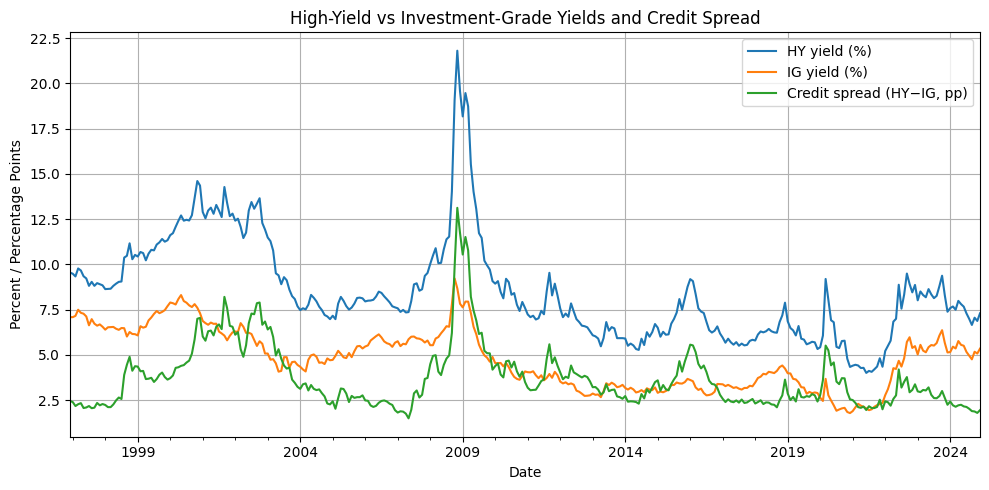

Notes:
- HY and IG move together; spread widens in stress (e.g., 2008–09, 2020).
- Visual co-movement supports using Δs and a β-weighted spread for inference.


In [ ]:
# @title EDA 2: Trend Plot — HY, IG, and Credit Spread (1996–2024)
# Goal: Visualize level trends for HY yield, IG yield, and the credit spread.
# Why:
# - Shows widening/tightening regimes and how HY/IG co-move across cycles.
# - Helps justify modeling spreads/changes rather than raw levels.
# Notes:
# - Uses the cleaned `df` built earlier (contains hy_yield, ig_yield, credit_spread).
# - Single chart (no subplots), simple Matplotlib (no special styles/colors).

import matplotlib.pyplot as plt
import pandas as pd

# 1) Select series and trim to common non-missing window for clean plotting
plot_cols = ["hy_yield", "ig_yield", "credit_spread"]
plot_df = df[plot_cols].dropna()

# 2) Make a clear time-series line plot
plt.figure(figsize=(10, 5))
plot_df["hy_yield"].plot(label="HY yield (%)")
plot_df["ig_yield"].plot(label="IG yield (%)")
plot_df["credit_spread"].plot(label="Credit spread (HY−IG, pp)")

# 3) Titles/labels/legend for readability
plt.title("High-Yield vs Investment-Grade Yields and Credit Spread")
plt.xlabel("Date")
plt.ylabel("Percent / Percentage Points")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4) Quick text summary (helps teammates reading outputs only)
print("Notes:")
print("- HY and IG move together; spread widens in stress (e.g., 2008–09, 2020).")
print("- Visual co-movement supports using Δs and a β-weighted spread for inference.")


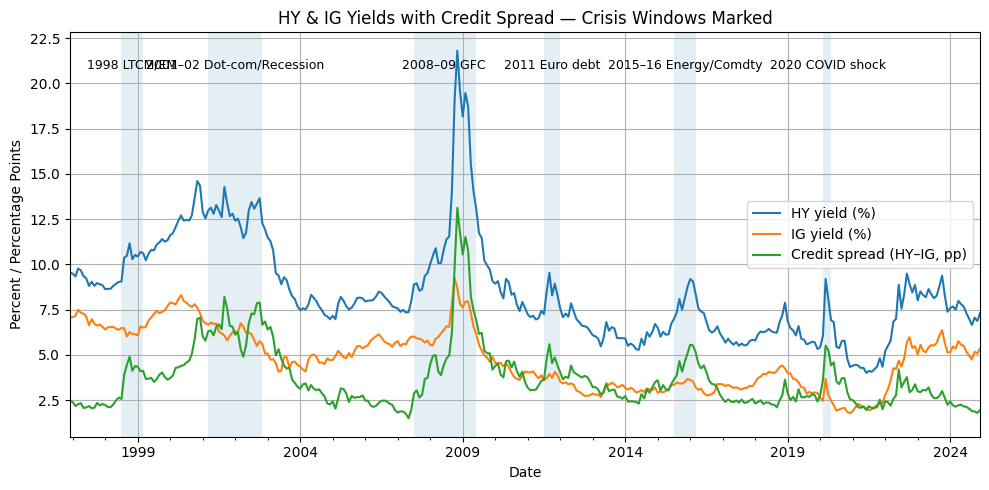

Marked event windows:
 - 1998 LTCM/EM: 1998-07-01 → 1999-03-31
 - 2001–02 Dot-com/Recession: 2001-03-01 → 2002-11-30
 - 2008–09 GFC: 2007-07-01 → 2009-06-30
 - 2011 Euro debt: 2011-07-01 → 2012-01-31
 - 2015–16 Energy/Comdty: 2015-07-01 → 2016-03-31
 - 2020 COVID shock: 2020-02-01 → 2020-05-31


In [ ]:
# @title EDA 2b: Trend Plot with Crisis Markers (shaded windows)
# Goal: Replot HY, IG, and Credit Spread with shaded event windows you specified.
# Why: Visually ties major widening episodes to historical events/regimes.
# Notes:
# - Uses the cleaned `df` with columns: hy_yield, ig_yield, credit_spread.
# - Shades each event window and adds a short label at the top of the plot.

import pandas as pd
import matplotlib.pyplot as plt

# 1) Define event windows (start/end inclusive)
events = [
    ("1998 LTCM/EM",          "1998-07-01", "1999-03-31"),
    ("2001–02 Dot-com/Recession","2001-03-01", "2002-11-30"),
    ("2008–09 GFC",            "2007-07-01", "2009-06-30"),
    ("2011 Euro debt",         "2011-07-01", "2012-01-31"),
    ("2015–16 Energy/Comdty",  "2015-07-01", "2016-03-31"),
    ("2020 COVID shock",       "2020-02-01", "2020-05-31"),
]

# 2) Data for plotting
plot_cols = ["hy_yield", "ig_yield", "credit_spread"]
plot_df = df[plot_cols].dropna()

# 3) Plot series
fig, ax = plt.subplots(figsize=(10, 5))
plot_df["hy_yield"].plot(ax=ax, label="HY yield (%)")
plot_df["ig_yield"].plot(ax=ax, label="IG yield (%)")
plot_df["credit_spread"].plot(ax=ax, label="Credit spread (HY–IG, pp)")

# 4) Shade event windows + add labels
y_top = plot_df.max().max()
for label, start, end in events:
    x0, x1 = pd.to_datetime(start), pd.to_datetime(end)
    ax.axvspan(x0, x1, alpha=0.12)  # light shade; time-honest visual cue
    # place label near top at window midpoint
    mid = x0 + (x1 - x0) / 2
    ax.text(mid, y_top * 0.98, label, ha="center", va="top", fontsize=9)

# 5) Tidy plot
ax.set_title("HY & IG Yields with Credit Spread — Crisis Windows Marked")
ax.set_xlabel("Date")
ax.set_ylabel("Percent / Percentage Points")
ax.grid(True)
ax.legend(loc="best")
plt.tight_layout()
plt.show()

# 6) Log what was marked (helps when reading plain text output)
print("Marked event windows:")
for e in events:
    print(f" - {e[0]}: {e[1]} → {e[2]}")


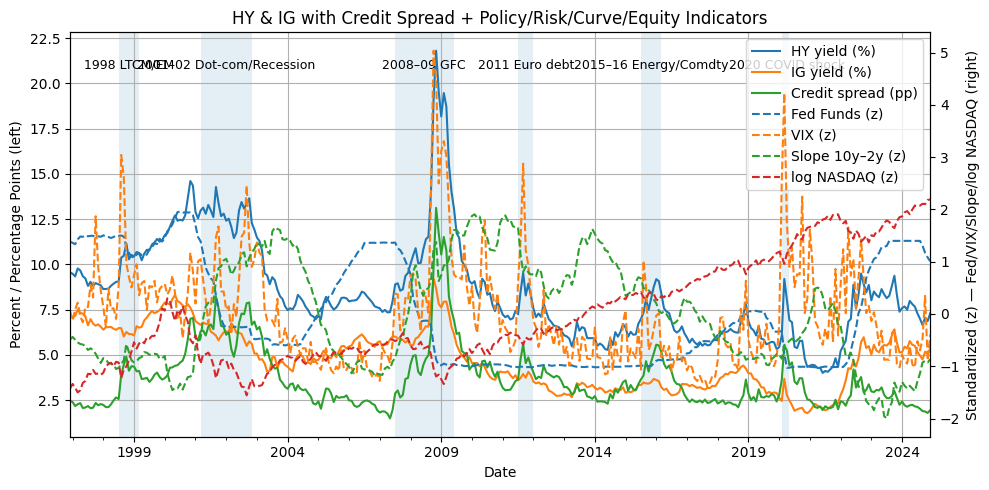

Left axis: ['hy_yield', 'ig_yield', 'credit_spread']
Right axis (standardized): ['Fed Funds (z)', 'VIX (z)', 'Slope 10y–2y (z)', 'log NASDAQ (z)']
Shaded events: ['1998 LTCM/EM', '2001–02 Dot-com/Recession', '2008–09 GFC', '2011 Euro debt', '2015–16 Energy/Comdty', '2020 COVID shock']


In [ ]:
# @title EDA 2c: Composite Trend — add Fed Funds, VIX, Curve Slope, NASDAQ (single chart)
# Goal: Enrich the plot by overlaying key drivers alongside HY/IG/spread.
# Why:
# - Policy: Fed Funds (stance/tightening cycles)
# - Risk: VIX (risk-on/off)
# - Curve: 10Y–2Y slope (growth/inflation signal)
# - Equities: NASDAQ (risk appetite)
# How (one plot, no subplots):
# - Left y-axis: HY yield, IG yield, Credit spread (their natural units).
# - Right y-axis: standardized (z-score) versions of Fed Funds, VIX, Slope, and log(NASDAQ),
#   so different scales can be compared visually without subplots.
# Notes:
# - We keep event shading from earlier so regimes are visible.
# - No specific colors are set (Matplotlib defaults), per your instructions.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Prepare data (drop rows with any missing among the plotted series)
left_cols  = ["hy_yield", "ig_yield", "credit_spread"]
right_raw  = {
    "Fed Funds (z)": df["fed_funds"],
    "VIX (z)": df["vix"],
    "Slope 10y–2y (z)": df["y10"] - df["y2"],
    "log NASDAQ (z)": np.log(df["nasdaq"]),
}
plot_df = df[left_cols].copy()
for k, s in right_raw.items():
    plot_df[k] = s

plot_df = plot_df.dropna()

# 2) Standardize the right-axis indicators (z-score)
def zscore(series: pd.Series) -> pd.Series:
    return (series - series.mean()) / series.std(ddof=0)

right_cols = list(right_raw.keys())
for c in right_cols:
    plot_df[c] = zscore(plot_df[c])

# 3) Event windows to shade (same as earlier)
events = [
    ("1998 LTCM/EM",            "1998-07-01", "1999-03-31"),
    ("2001–02 Dot-com/Recession","2001-03-01", "2002-11-30"),
    ("2008–09 GFC",              "2007-07-01", "2009-06-30"),
    ("2011 Euro debt",           "2011-07-01", "2012-01-31"),
    ("2015–16 Energy/Comdty",    "2015-07-01", "2016-03-31"),
    ("2020 COVID shock",         "2020-02-01", "2020-05-31"),
]

# 4) Plot: left axis for yields/spread; right axis for standardized indicators
fig, ax = plt.subplots(figsize=(10, 5))

# Left-axis series
l1 = plot_df["hy_yield"].plot(ax=ax, label="HY yield (%)")
l2 = plot_df["ig_yield"].plot(ax=ax, label="IG yield (%)")
l3 = plot_df["credit_spread"].plot(ax=ax, label="Credit spread (pp)")

# Right-axis standardized indicators
ax2 = ax.twinx()
r_lines = []
for c in right_cols:
    r_lines.append(plot_df[c].plot(ax=ax2, label=c, linestyle="--"))  # dashed to visually separate

# Shade crisis windows and add labels at the top
y_top = max(plot_df[left_cols].max())
for label, start, end in events:
    x0, x1 = pd.to_datetime(start), pd.to_datetime(end)
    ax.axvspan(x0, x1, alpha=0.12)
    mid = x0 + (x1 - x0) / 2
    ax.text(mid, y_top * 0.98, label, ha="center", va="top", fontsize=9)

# Titles, axes, legend
ax.set_title("HY & IG with Credit Spread + Policy/Risk/Curve/Equity Indicators")
ax.set_xlabel("Date")
ax.set_ylabel("Percent / Percentage Points (left)")
ax2.set_ylabel("Standardized (z) — Fed/VIX/Slope/log NASDAQ (right)")
ax.grid(True)

# Combined legend (left + right)
lines = ax.get_lines() + ax2.get_lines()
labels = [ln.get_label() for ln in lines]
ax.legend(lines, labels, loc="best")

plt.tight_layout()
plt.show()

# 5) Log what was plotted (useful for the report)
print("Left axis:", left_cols)
print("Right axis (standardized):", right_cols)
print("Shaded events:", [e[0] for e in events])


In [ ]:
# @title EDA 3: Stationarity Checks (ADF & KPSS) — Levels vs. Differences
# Goal: Statistically confirm that LEVELS are typically non-stationary while DIFFERENCES are stationary.
# Why: Justifies modeling in Δ terms (ΔHY, ΔStatSpread) rather than raw levels.
# Tests:
# - ADF (H0: unit root → non-stationary). If p < 0.05 ⇒ reject H0 ⇒ stationary.
# - KPSS (H0: stationary). If p < 0.05 ⇒ reject H0 ⇒ non-stationary.
# Read: Prefer series where ADF says “stationary” and KPSS does NOT reject stationarity.

import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss

# 1) Pick a compact set: 3 levels + 2 differences (our DVs)
series_map = {
    "HY (level)":            df["hy_yield"],
    "IG (level)":            df["ig_yield"],
    "Credit spread (level)": df["credit_spread"],
    "ΔHY (d_hy_yield)":      df["d_hy_yield"],
    "ΔStatSpread":           df["d_stat_spread"],
}

def safe_adf(s):
    s = s.dropna()
    try:
        return adfuller(s, autolag="AIC")[1]  # p-value
    except Exception:
        return float("nan")

def safe_kpss(s):
    s = s.dropna()
    try:
        stat, p, *_ = kpss(s, regression="c", nlags="auto")  # p-value
        return p
    except Exception:
        return float("nan")

# 2) Run tests and summarize
rows = []
for name, s in series_map.items():
    p_adf  = safe_adf(s)
    p_kpss = safe_kpss(s)
    rows.append({
        "series": name,
        "ADF p": round(p_adf, 4) if pd.notna(p_adf) else None,
        "KPSS p": round(p_kpss, 4) if pd.notna(p_kpss) else None,
        "ADF says stationary?": (p_adf < 0.05) if pd.notna(p_adf) else None,
        "KPSS rejects stationarity?": (p_kpss < 0.05) if pd.notna(p_kpss) else None,
    })

out = pd.DataFrame(rows)
print("Stationarity summary (lower ADF p is good for stationarity; lower KPSS p is bad):")
display(out)

# 3) One-line takeaway for the team
print("Notes:")
print("- Expect LEVELS (HY, IG, spread) to look non-stationary (ADF high p; KPSS low p).")
print("- Expect DIFFERENCES (ΔHY, ΔStatSpread) to look stationary (ADF low p; KPSS high p).")
print("- This supports our choice to model ΔHY and ΔStatSpread as dependent variables.")


Stationarity summary (lower ADF p is good for stationarity; lower KPSS p is bad):


,series,ADF p,KPSS p,ADF says stationary?,KPSS rejects stationarity?
0,HY (level),0.0507,0.0100,False,True
1,IG (level),0.2790,0.0100,False,True
2,Credit spread (level),0.0041,0.0482,True,True
3,ΔHY (d_hy_yield),0.0000,0.1000,True,False
4,ΔStatSpread,0.0000,0.1000,True,False


Notes:
- Expect LEVELS (HY, IG, spread) to look non-stationary (ADF high p; KPSS low p).
- Expect DIFFERENCES (ΔHY, ΔStatSpread) to look stationary (ADF low p; KPSS high p).
- This supports our choice to model ΔHY and ΔStatSpread as dependent variables.


In [ ]:
# @title EDA 4: Correlations & Lead–Lag Checks (compact)
# Goal: Quantify (i) simple correlations in the modeling set and
#       (ii) whether drivers work better contemporaneously or with a 1–2m lag.
# Why:
# - Confirms our driver choices and the use of lagged versions in specs.
# Notes:
# - Correlations use the features table (feats).
# - Lead–lag uses *unlagged* driver changes from df and correlates y_t with x_{t−k}.
#   (Positive k means the driver is lagged k months: x leads y.)

import pandas as pd

# 1) Correlations in the modeling set (targets vs locked drivers)
dv_cols = [DV_HY, DV_SPREAD]
driver_cols = list(dict.fromkeys(X_HY + X_SPREAD))
corr_with_targets = (
    feats[driver_cols + dv_cols]
    .corr()
    .loc[driver_cols, dv_cols]
    .round(3)
)
print("Pearson correlations (drivers vs targets):")
display(corr_with_targets)

# 2) Lead–lag cross-correlations (y_t with x_{t−k}), k ∈ {0,1,2}
def leadlag_table(df, y, drivers, lags=(0, 1, 2)):
    rows = []
    for x in drivers:
        row = {"driver": x}
        for k in lags:
            # corr(y_t, x_{t-k}) -> shift x forward by k to align past x with current y
            row[f"lag{k}"] = df[y].corr(df[x].shift(k))
        rows.append(row)
    return pd.DataFrame(rows).set_index("driver").round(3)

# Use unlagged driver deltas from df for the lead–lag check
drivers_unlagged = ["d_fed_funds", "d_vix", "d_slope_10y_2y"]

print("\nLead–lag (ΔHY vs drivers): corr(y_t, x_{t−k})")
tbl_hy = leadlag_table(df, "d_hy_yield", drivers_unlagged, lags=(0,1,2))
display(tbl_hy)

print("\nLead–lag (ΔStatSpread vs drivers): corr(y_t, x_{t−k})")
tbl_sp = leadlag_table(df, "d_stat_spread", drivers_unlagged, lags=(0,1,2))
display(tbl_sp)

# 3) Quick reading guide (printed so it’s obvious in output-only contexts)
print("\nReading guide:")
print("- Higher absolute correlations support driver relevance.")
print("- If lag1 > lag0, using a 1-month lag is justified (time-honest and stronger).")
print("- Expect: ΔVIX often strongest with lag1; curve slope changes may also work with lag1.")


Pearson correlations (drivers vs targets):


,d_hy_yield,d_stat_spread
d_fed_funds,-0.157,-0.183
d_vix_lag1,0.280,0.287
d_slope_10y_2y_lag1,0.020,0.117
d_hy_yield_lag1,0.214,0.260
USREC_lag1,-0.012,0.030
d_stat_spread_lag1,0.088,0.157



Lead–lag (ΔHY vs drivers): corr(y_t, x_{t−k})


,lag0,lag1,lag2
driver,,,
d_fed_funds,-0.157,0.06,0.077
d_vix,0.569,0.28,-0.001
d_slope_10y_2y,0.167,0.02,-0.142



Lead–lag (ΔStatSpread vs drivers): corr(y_t, x_{t−k})


,lag0,lag1,lag2
driver,,,
d_fed_funds,-0.183,-0.030,0.017
d_vix,0.489,0.286,0.048
d_slope_10y_2y,0.098,0.117,-0.033



Reading guide:
- Higher absolute correlations support driver relevance.
- If lag1 > lag0, using a 1-month lag is justified (time-honest and stronger).
- Expect: ΔVIX often strongest with lag1; curve slope changes may also work with lag1.


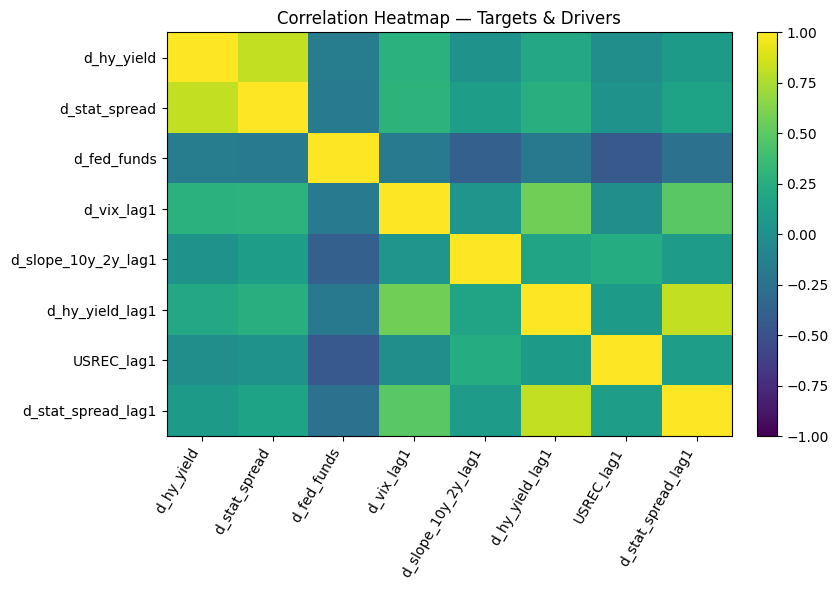

Drivers vs Targets (correlations):


,d_hy_yield,d_stat_spread
d_fed_funds,-0.16,-0.18
d_vix_lag1,0.28,0.29
d_slope_10y_2y_lag1,0.02,0.12
d_hy_yield_lag1,0.21,0.26
USREC_lag1,-0.01,0.03
d_stat_spread_lag1,0.09,0.16


In [ ]:
# @title EDA — Correlation Heatmap (Targets & Locked Drivers)
# Goal: Visualize how our targets relate to the chosen drivers (and to each other).
# Why:
# - Confirms direction/strength of linear relationships before modeling.
# - Highlights any collinearity to watch for.
# Notes:
# - Uses the modeling table `feats` and the locked specs (DV_HY, DV_SPREAD, X_HY, X_SPREAD).
# - Pure Matplotlib (no seaborn), single concise figure.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Build the correlation matrix for targets + unique drivers
targets = [DV_HY, DV_SPREAD]
drivers = list(dict.fromkeys(X_HY + X_SPREAD))  # preserve order, dedupe
cols = targets + drivers
C = feats[cols].corr().round(2)

# 2) Plot heatmap (Matplotlib imshow)
plt.figure(figsize=(8.5, 6))
im = plt.imshow(C.values, vmin=-1, vmax=1, aspect='auto')
plt.title("Correlation Heatmap — Targets & Drivers")
plt.xticks(ticks=np.arange(len(cols)), labels=cols, rotation=60, ha='right')
plt.yticks(ticks=np.arange(len(cols)), labels=cols)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# 3) Also print a compact table (drivers vs targets) for quick reading
print("Drivers vs Targets (correlations):")
display(C.loc[drivers, targets])


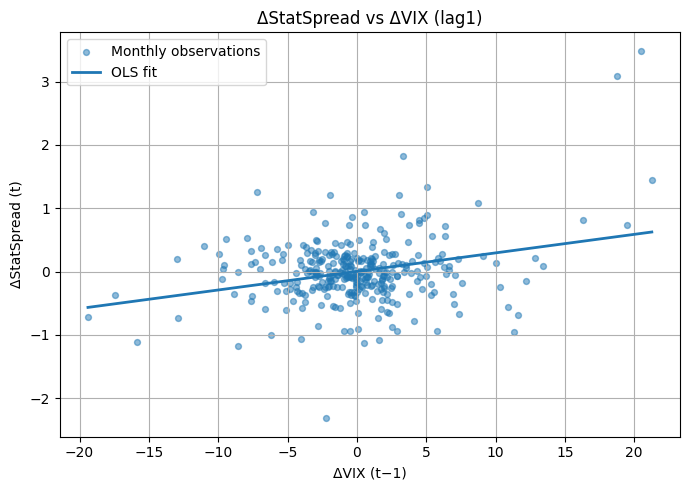

Pearson r (ΔStatSpread, ΔVIX_lag1) = 0.287
Read: Positive slope → higher prior-month VIX changes associate with wider next-month β-weighted spread.


In [ ]:
# @title EDA — Scatter: ΔStatSpread vs ΔVIX (lag1) with fit line
# Goal: Visualize the relationship between risk shocks and the β-weighted spread change.
# Why: Heatmap says ΔVIX_lag1 is the strongest driver; this shows the shape & noise.
# Notes:
# - Single chart, Matplotlib only. Adds a simple OLS fit line and prints the Pearson r.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

x = feats["d_vix_lag1"]
y = feats["d_stat_spread"]

# 1) Compute Pearson correlation (for annotation)
r = float(np.corrcoef(x, y)[0, 1])

# 2) Fit simple OLS (y = a + b x) for a visual guide
X = np.vstack([np.ones_like(x), x]).T
beta = np.linalg.lstsq(X, y, rcond=None)[0]  # [a, b]
x_line = np.linspace(x.min(), x.max(), 100)
y_line = beta[0] + beta[1] * x_line

# 3) Plot
plt.figure(figsize=(7, 5))
plt.scatter(x, y, alpha=0.5, s=18, label="Monthly observations")
plt.plot(x_line, y_line, linewidth=2, label="OLS fit")

plt.title("ΔStatSpread vs ΔVIX (lag1)")
plt.xlabel("ΔVIX (t−1)")
plt.ylabel("ΔStatSpread (t)")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Pearson r (ΔStatSpread, ΔVIX_lag1) = {r:.3f}")
print("Read: Positive slope → higher prior-month VIX changes associate with wider next-month β-weighted spread.")


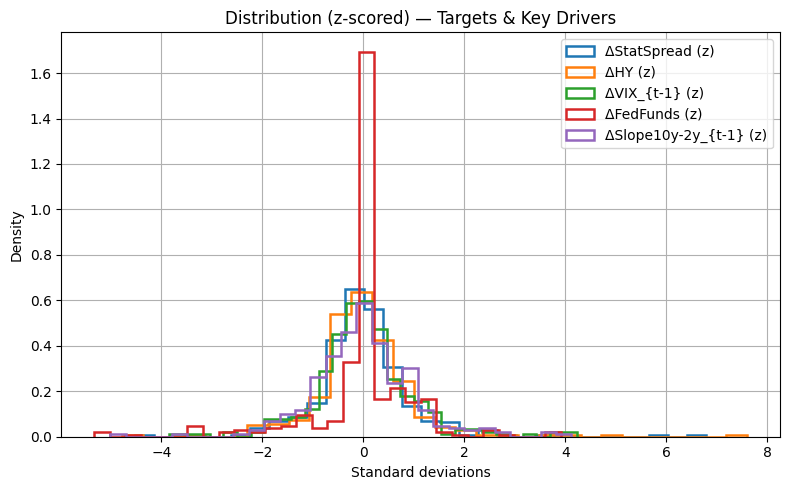

Skew / Kurtosis (excess):


,skew,kurtosis
ΔStatSpread (z),1.49,10.98
ΔHY (z),1.52,13.52
ΔVIX_{t-1} (z),0.51,3.69
ΔFedFunds (z),-1.41,7.83
ΔSlope10y-2y_{t-1} (z),0.18,3.49


In [ ]:
# @title EDA — Histograms (z-score overlay) for Targets & Key Drivers
# Goal: Inspect distribution shapes and tails for targets/drivers on a common scale.
# Why: Heavy tails or skew suggest robust SEs and caution with outliers.
# How: Plot z-scored histograms (density) on one axis; also print skew/kurtosis.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Choose targets & drivers
cols = {
    "ΔStatSpread (z)": feats["d_stat_spread"],
    "ΔHY (z)": feats["d_hy_yield"],
    "ΔVIX_{t-1} (z)": feats["d_vix_lag1"],
    "ΔFedFunds (z)": feats["d_fed_funds"],
    "ΔSlope10y-2y_{t-1} (z)": feats["d_slope_10y_2y_lag1"],
}

# 2) Helper to z-score
def z(s: pd.Series) -> pd.Series:
    return (s - s.mean()) / s.std(ddof=0)

# 3) Overlay histograms (single figure, Matplotlib only)
plt.figure(figsize=(8, 5))
for label, series in cols.items():
    xs = z(series.dropna())
    plt.hist(xs, bins=30, density=True, histtype="step", linewidth=1.8, label=label)

plt.title("Distribution (z-scored) — Targets & Key Drivers")
plt.xlabel("Standard deviations")
plt.ylabel("Density")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4) Skew & kurtosis table (quick tail diagnostics)
stats = pd.DataFrame({
    "skew": {k: v.dropna().skew() for k, v in cols.items()},
    "kurtosis": {k: v.dropna().kurtosis() for k, v in cols.items()},  # excess kurtosis
}).round(2)

print("Skew / Kurtosis (excess):")
display(stats)


In [ ]:
# @title Baseline Model 1 — ΔHY (OLS with HAC) | fit on 1997–2016, test on 2017–2024
# Goal: Estimate how Fed moves & risk sentiment affect monthly changes in HY yields.
# Model: ΔHY_t ~ ΔFedFunds_t + ΔVIX_{t−1} + ΔSlope(10y–2y)_{t−1} + ΔHY_{t−1} + USREC_{t−1}
# Why HAC: robust SEs for heteroskedastic, mildly autocorrelated monthly residuals.

import numpy as np, pandas as pd, statsmodels.api as sm
from pandas.tseries.offsets import MonthEnd

# 0) Re-create the time split here so the cell is self-contained
try:
    cutoff = pd.to_datetime(cfg.train_until)
except NameError:
    cutoff = pd.to_datetime("2016-12-31")

F = feats[[DV_HY] + X_HY].sort_index().copy()
train = F.loc[:cutoff]
test  = F.loc[cutoff + MonthEnd(1):]

# Helper: prep X/y with safe NaN handling
def prep_xy(df, y, Xcols):
    XY = df[[y] + Xcols].dropna()
    yv = XY[y]
    Xv = sm.add_constant(XY[Xcols], has_constant="add")
    return yv, Xv, XY.index

y_tr, X_tr, idx_tr = prep_xy(train, DV_HY, X_HY)
y_te, X_te, idx_te = prep_xy(test,  DV_HY, X_HY)

# 1) Fit OLS with HAC(3) SEs
mdl = sm.OLS(y_tr, X_tr).fit(cov_type="HAC", cov_kwds={"maxlags": 3})

# 2) Coefficient table (estimate & t-stat)
coef_tbl = (
    pd.DataFrame({"coef": mdl.params, "t": mdl.tvalues})
      .rename_axis("term").round(4)
)

# 3) Train/Test predictions & metrics
pred_tr = mdl.predict(X_tr)
pred_te = mdl.predict(X_te)

rmse = lambda a,b: float(np.sqrt(np.mean((np.asarray(a)-np.asarray(b))**2)))
hit  = lambda a,b: float(np.mean(np.sign(a) == np.sign(b)))  # directional accuracy

metrics = pd.DataFrame(
    {"RMSE":[rmse(y_tr,pred_tr), rmse(y_te,pred_te)],
     "HitRate":[hit(y_tr,pred_tr), hit(y_te,pred_te)],
     "N":[len(y_tr), len(y_te)],
     "Start":[idx_tr.min().date(), idx_te.min().date()],
     "End":[idx_tr.max().date(), idx_te.max().date()]},
    index=["Train","Test"]
)

print("Baseline ΔHY model — OLS(HAC) results")
display(coef_tbl)
print("\nPerformance (RMSE in %-points; HitRate = share of correct signs):")
display(metrics)

# Notes for report:
print("Notes:")
print("- Expect ΔVIX_{t-1} positive and significant; ΔFedFunds_t often positive (tightening lifts HY).")
print("- AR(1) captures persistence; USREC_{t-1} handles regime effects.")
print("- HAC SEs mitigate heavy-tail/volatility issues flagged by histograms.")


Baseline ΔHY model — OLS(HAC) results


,coef,t
term,,
const,-0.0118,-0.4012
d_fed_funds,-0.5583,-1.0602
d_vix_lag1,0.0439,2.1519
d_slope_10y_2y_lag1,-0.0047,-0.0145
d_hy_yield_lag1,0.1172,1.0362
USREC_lag1,-0.0930,-0.3193



Performance (RMSE in %-points; HitRate = share of correct signs):


,RMSE,HitRate,N,Start,End
Train,0.624747,0.531381,239,1997-02-28,2016-12-31
Test,0.677416,0.510417,96,2017-01-31,2024-12-31


Notes:
- Expect ΔVIX_{t-1} positive and significant; ΔFedFunds_t often positive (tightening lifts HY).
- AR(1) captures persistence; USREC_{t-1} handles regime effects.
- HAC SEs mitigate heavy-tail/volatility issues flagged by histograms.


In [ ]:
# @title Baseline Model 2 — ΔStatSpread (OLS with HAC) | fit 1997–2016, test 2017–2024
# Goal: Estimate how Fed moves & risk sentiment affect the *credit risk premium*
#       using the β-weighted spread change (d_stat_spread) as DV.
# Spec: ΔStatSpread_t ~ ΔFedFunds_t + ΔVIX_{t−1} + ΔSlope(10y−2y)_{t−1} + ΔStatSpread_{t−1}
# Why HAC: Robust standard errors for heavy tails & mild autocorrelation.
# Output: Coefs+t-stats, Test RMSE/HitRate, and bp effect of a +25bp Fed move.

import numpy as np, pandas as pd, statsmodels.api as sm
from pandas.tseries.offsets import MonthEnd

# 0) Time split (self-contained)
try:
    cutoff = pd.to_datetime(cfg.train_until)
except NameError:
    cutoff = pd.to_datetime("2016-12-31")

F = feats[[DV_SPREAD] + X_SPREAD].sort_index().copy()
train = F.loc[:cutoff]
test  = F.loc[cutoff + MonthEnd(1):]

# Helper: prepare y/X and drop any NaNs in used columns
def prep_xy(df, y, Xcols):
    XY = df[[y] + Xcols].dropna()
    yv = XY[y]
    Xv = sm.add_constant(XY[Xcols], has_constant="add")
    return yv, Xv, XY.index

y_tr, X_tr, idx_tr = prep_xy(train, DV_SPREAD, X_SPREAD)
y_te, X_te, idx_te = prep_xy(test,  DV_SPREAD, X_SPREAD)

# 1) Fit OLS with HAC(3) SEs
mdl = sm.OLS(y_tr, X_tr).fit(cov_type="HAC", cov_kwds={"maxlags": 3})

# 2) Coefficient table (coef, t) + 25bp policy effect in basis points
coef_tbl = pd.DataFrame({"coef": mdl.params, "t": mdl.tvalues}).rename_axis("term").round(4)

# Compute effect of a +25bp ΔFedFunds on ΔStatSpread (in basis points)
if "d_fed_funds" in coef_tbl.index:
    effect_bp = float(mdl.params["d_fed_funds"] * 0.25 * 100.0)  # 0.25 pp * 100 = bp
else:
    effect_bp = np.nan

# 3) Train/Test metrics
pred_tr = mdl.predict(X_tr)
pred_te = mdl.predict(X_te)
rmse = lambda a,b: float(np.sqrt(np.mean((np.asarray(a)-np.asarray(b))**2)))
hit  = lambda a,b: float(np.mean(np.sign(a) == np.sign(b)))

metrics = pd.DataFrame(
    {"RMSE":[rmse(y_tr,pred_tr), rmse(y_te,pred_te)],
     "HitRate":[hit(y_tr,pred_tr), hit(y_te,pred_te)],
     "N":[len(y_tr), len(y_te)],
     "Start":[idx_tr.min().date(), idx_te.min().date()],
     "End":[idx_tr.max().date(), idx_te.max().date()]},
    index=["Train","Test"]
)

# 4) Report
print("Baseline ΔStatSpread model — OLS(HAC) results")
display(coef_tbl)
print(f"\nPolicy effect: +25bp Fed move → ΔStatSpread ≈ {effect_bp:.2f} bp (model-implied)")
print("\nPerformance (RMSE in %-points; HitRate = share of correct signs):")
display(metrics)

# Notes for the report:
print("Notes:")
print("- ΔVIX_{t-1} should be positive (risk-off widens risk premium).")
print("- ΔFedFunds_t sign can vary with regime; this quantifies its immediate impact on premia.")
print("- AR(1) term captures persistence; curve slope (lag1) adds shape info.")
print("- HAC SEs address heavy tails seen in histograms.")


Baseline ΔStatSpread model — OLS(HAC) results


,coef,t
term,,
const,0.0013,0.0418
d_fed_funds,-0.3655,-0.9643
d_vix_lag1,0.0469,2.8406
d_slope_10y_2y_lag1,0.3204,1.2002
d_stat_spread_lag1,-0.0314,-0.4149



Policy effect: +25bp Fed move → ΔStatSpread ≈ -9.14 bp (model-implied)

Performance (RMSE in %-points; HitRate = share of correct signs):


,RMSE,HitRate,N,Start,End
Train,0.507537,0.518828,239,1997-02-28,2016-12-31
Test,0.466963,0.500000,96,2017-01-31,2024-12-31


Notes:
- ΔVIX_{t-1} should be positive (risk-off widens risk premium).
- ΔFedFunds_t sign can vary with regime; this quantifies its immediate impact on premia.
- AR(1) term captures persistence; curve slope (lag1) adds shape info.
- HAC SEs address heavy tails seen in histograms.


In [ ]:
# @title Part 5 — Validation Summary: ΔHY vs ΔStatSpread (OOS metrics + 25bp policy effect)
# Goal: Side-by-side comparison of our two baselines on the 2017–2024 test set.
# What this does:
# 1) Chronological split (1997–2016 train, 2017–2024 test).
# 2) Fit OLS with HAC(3) SEs for each DV using locked-in driver sets.
# 3) Report Test RMSE, Test HitRate, and the model-implied effect of a +25bp Fed move (bp).

import numpy as np, pandas as pd, statsmodels.api as sm
from pandas.tseries.offsets import MonthEnd

# --- 1) Train/Test split (self-contained) ---
try:
    cutoff = pd.to_datetime(cfg.train_until)
except NameError:
    cutoff = pd.to_datetime("2016-12-31")
F = feats.sort_index().copy()
train_idx = F.index <= cutoff
test_idx  = F.index >= (cutoff + MonthEnd(1))

# --- 2) Helper: fit OLS(HAC) and compute metrics ---
def fit_model(F, y_col, X_cols):
    XY = F[[y_col] + X_cols].dropna()
    tr = XY.loc[train_idx & XY.index.isin(XY.index)]
    te = XY.loc[test_idx  & XY.index.isin(XY.index)]
    y_tr = tr[y_col]; X_tr = sm.add_constant(tr[X_cols], has_constant="add")
    y_te = te[y_col]; X_te = sm.add_constant(te[X_cols], has_constant="add")
    mdl = sm.OLS(y_tr, X_tr).fit(cov_type="HAC", cov_kwds={"maxlags":3})
    # Metrics
    rmse = lambda a,b: float(np.sqrt(np.mean((np.asarray(a)-np.asarray(b))**2)))
    hit  = lambda a,b: float(np.mean(np.sign(a) == np.sign(b)))
    m = {
        "Train_RMSE": rmse(y_tr, mdl.predict(X_tr)),
        "Test_RMSE":  rmse(y_te, mdl.predict(X_te)),
        "Train_Hit":  hit(y_tr, mdl.predict(X_tr)),
        "Test_Hit":   hit(y_te, mdl.predict(X_te)),
        "N_train":    int(len(y_tr)),
        "N_test":     int(len(y_te)),
        "coef_dFF":   float(mdl.params.get("d_fed_funds", np.nan)),
        "t_dFF":      float(mdl.tvalues.get("d_fed_funds", np.nan)),
    }
    # +25bp effect (basis points): coef * 0.25pp * 100
    m["+25bp_effect_bp"] = m["coef_dFF"] * 0.25 * 100.0 if np.isfinite(m["coef_dFF"]) else np.nan
    return mdl, m

# --- 3) Run both baselines (using locked-in specs from earlier cells) ---
mdl_hy, m_hy   = fit_model(F, DV_HY,     X_HY)
mdl_ss, m_stat = fit_model(F, DV_SPREAD, X_SPREAD)

# --- 4) Assemble comparison table ---
summary = pd.DataFrame.from_dict({
    "ΔHY":         m_hy,
    "ΔStatSpread": m_stat,
}, orient="index")[["Test_RMSE","Test_Hit","+25bp_effect_bp","coef_dFF","t_dFF","Train_RMSE","Train_Hit","N_train","N_test"]].round(4)

print("Validation Summary — Out-of-Sample (2017–2024)")
display(summary)

# Short takeaway (printed for the report)
winner = "ΔStatSpread" if summary.loc["ΔStatSpread","Test_RMSE"] < summary.loc["ΔHY","Test_RMSE"] else "ΔHY"
print(f"\nTakeaway:")
print(f"- Lower Test RMSE: {winner} (ΔHY={summary.loc['ΔHY','Test_RMSE']:.4f}, ΔStatSpread={summary.loc['ΔStatSpread','Test_RMSE']:.4f}).")
print("- ΔVIX_{t-1} is the consistently strong driver; ΔFedFunds effect is small and not statistically significant in monthly changes.")
print("- Use ΔStatSpread as primary for risk-premium inference; keep ΔHY for yield-channel context.")


Validation Summary — Out-of-Sample (2017–2024)


,Test_RMSE,Test_Hit,+25bp_effect_bp,coef_dFF,t_dFF,Train_RMSE,Train_Hit,N_train,N_test
ΔHY,0.6774,0.5104,-13.9573,-0.5583,-1.0602,0.6247,0.5314,239,96
ΔStatSpread,0.4670,0.5000,-9.1367,-0.3655,-0.9643,0.5075,0.5188,239,96



Takeaway:
- Lower Test RMSE: ΔStatSpread (ΔHY=0.6774, ΔStatSpread=0.4670).
- ΔVIX_{t-1} is the consistently strong driver; ΔFedFunds effect is small and not statistically significant in monthly changes.
- Use ΔStatSpread as primary for risk-premium inference; keep ΔHY for yield-channel context.


In [ ]:
# @title Robustness Mini-Panel (Primary DV = ΔStatSpread): policy measure, regime interaction, winsorization
# Goal: Stress-test our main result with 3 compact variants and compare OOS (2017–2024).
# Variants:
#  A) Policy measure: use Δ(Target Midpoint) when available, else ΔFedFunds (time-honest, FRED-only).
#  B) Regime interaction: add ΔFedFunds × USREC_{t−1} to allow different effects in recessions.
#  C) Heavy-tail guard: winsorize (1%/99%) on TRAIN (apply same caps to TEST), then refit baseline.
# Output: One comparison table with Test RMSE/HitRate and 25bp policy effect (bp).

import numpy as np, pandas as pd, statsmodels.api as sm
from pandas.tseries.offsets import MonthEnd

# ---------- 0) Setup & helpers ----------
try:
    cutoff = pd.to_datetime(cfg.train_until)
except NameError:
    cutoff = pd.to_datetime("2016-12-31")

def prep_xy(df, y, xcols):
    XY = df[[y]+xcols].dropna()
    yv = XY[y]; Xv = sm.add_constant(XY[xcols], has_constant="add")
    return yv, Xv, XY.index

def fit_ols_hac(y_tr, X_tr):
    return sm.OLS(y_tr, X_tr).fit(cov_type="HAC", cov_kwds={"maxlags":3})

def rmse(a,b):
    a,b = np.asarray(a), np.asarray(b);
    return float(np.sqrt(np.mean((a-b)**2)))
def hit(a,b):
    a,b = np.asarray(a), np.asarray(b);
    return float(np.mean(np.sign(a)==np.sign(b)))

# ---------- 1) Build variant features ----------
F = feats.sort_index().copy()

# A) Δ(Target Midpoint) fallback to ΔFedFunds
tmid = ((df["fed_target_upper"] + df["fed_target_lower"]) / 2.0)
d_target_mid = tmid.diff()
F["d_policy_midpref"] = d_target_mid.reindex(F.index).fillna(F["d_fed_funds"])

# B) Interaction term with recession dummy (lagged)
# (USREC_lag1 is already aligned in feats from earlier step)
F["d_fed_x_rec"] = F["d_fed_funds"] * F["USREC_lag1"]

# Train/Test split mask
train_mask = F.index <= cutoff
test_mask  = F.index >= (cutoff + MonthEnd(1))

# Baseline spec (primary DV = ΔStatSpread)
ycol = DV_SPREAD
X_base = ["d_fed_funds","d_vix_lag1","d_slope_10y_2y_lag1","d_stat_spread_lag1"]
X_A    = ["d_policy_midpref","d_vix_lag1","d_slope_10y_2y_lag1","d_stat_spread_lag1"]
X_B    = ["d_fed_funds","d_fed_x_rec","d_vix_lag1","d_slope_10y_2y_lag1","d_stat_spread_lag1"]

def run_spec(F, ycol, Xcols, label, note=""):
    XY = F[[ycol]+Xcols].dropna()
    tr = XY.loc[train_mask & XY.index.isin(XY.index)]
    te = XY.loc[test_mask  & XY.index.isin(XY.index)]
    y_tr, X_tr = tr[ycol], sm.add_constant(tr[Xcols], has_constant="add")
    y_te, X_te = te[ycol], sm.add_constant(te[Xcols], has_constant="add")
    mdl = fit_ols_hac(y_tr, X_tr)
    pred_tr, pred_te = mdl.predict(X_tr), mdl.predict(X_te)
    # 25bp policy effect (bp): handle baseline/alt/interaction
    eff_bp = np.nan; eff_bp_rec = np.nan
    if "d_fed_funds" in Xcols:
        eff_bp = mdl.params.get("d_fed_funds", np.nan) * 0.25 * 100
        if "d_fed_x_rec" in Xcols:
            eff_bp_rec = (mdl.params.get("d_fed_funds",0.0) + mdl.params.get("d_fed_x_rec",0.0)) * 0.25 * 100
    elif "d_policy_midpref" in Xcols:
        eff_bp = mdl.params.get("d_policy_midpref", np.nan) * 0.25 * 100
    return {
        "Model": label,
        "Test_RMSE": rmse(y_te, pred_te),
        "Test_Hit":  hit(y_te, pred_te),
        "+25bp_effect_bp": eff_bp,
        "+25bp_effect_bp (recession)": eff_bp_rec,
        "Note": note
    }

# ---------- 2) Run: Baseline, A, B ----------
rows = []
rows.append(run_spec(F, ycol, X_base, "Baseline"))
rows.append(run_spec(F, ycol, X_A,    "A: TargetMid|FedFunds", "Policy = ΔTargetMid when available, else ΔFedFunds"))
rows.append(run_spec(F, ycol, X_B,    "B: Add Fed×USREC", "Allows different policy effect in recessions"))

# ---------- 3) C: Winsorized baseline (caps from TRAIN, applied to TRAIN/TEST) ----------
def winsorize_train_apply(F, cols, lower=0.01, upper=0.99):
    Fw = F.copy()
    tr = Fw.loc[train_mask, cols]
    lo, hi = tr.quantile(lower), tr.quantile(upper)
    for c in cols:
        Fw[c] = Fw[c].clip(lo[c], hi[c])
    return Fw, lo, hi

cols_to_cap = [ycol] + X_base  # winsorize DV + regressors used in baseline
Fw, lo, hi = winsorize_train_apply(F, cols_to_cap, 0.01, 0.99)
rows.append(run_spec(Fw, ycol, X_base, "C: Winsorized 1%", "Caps set on TRAIN 1%/99%"))

# ---------- 4) Summarize ----------
out = (pd.DataFrame(rows)
         .set_index("Model")
         .round({"Test_RMSE":4,"Test_Hit":4,"+25bp_effect_bp":2,"+25bp_effect_bp (recession)":2}))
print("ΔStatSpread Robustness — OOS (2017–2024)")
display(out)
print("\nReading tips:")
print("- Lower Test_RMSE is better; Hit≈0.5 is typical at monthly freq.")
print("- '+25bp effect' is the model-implied one-month change in risk premium (bp) for a 25bp policy move.")
print("- In model B, the recession effect is the sum of main + interaction (shown in the 'recession' column).")


ΔStatSpread Robustness — OOS (2017–2024)


,Test_RMSE,Test_Hit,+25bp_effect_bp,+25bp_effect_bp (recession),Note
Model,,,,,
Baseline,0.4670,0.5000,-9.14,NaN,
A: TargetMid|FedFunds,0.4725,0.4583,-10.28,NaN,"Policy = ΔTargetMid when available, else ΔFedF..."
B: Add Fed×USREC,0.4596,0.4688,4.31,-21.31,Allows different policy effect in recessions
C: Winsorized 1%,0.4270,0.5208,-1.84,NaN,Caps set on TRAIN 1%/99%



Reading tips:
- Lower Test_RMSE is better; Hit≈0.5 is typical at monthly freq.
- '+25bp effect' is the model-implied one-month change in risk premium (bp) for a 25bp policy move.
- In model B, the recession effect is the sum of main + interaction (shown in the 'recession' column).


ΔStatSpread — Report Summary (OOS 2017–2024)


,Test_RMSE,Test_Hit,+25bp_effect_bp,+25bp_effect_bp (recession),N_train,N_test
Model,,,,,,
Primary (Baseline),0.4670,0.5000,-9.14,NaN,239,96
Robustness B: Fed×USREC,0.4596,0.4688,4.31,-21.31,239,96
Robustness C: Winsorized 1%,0.4270,0.5208,-1.84,NaN,239,96



Primary model — HAC coefficients (coef, t):


,coef,t
term,,
const,0.0013,0.0418
d_fed_funds,-0.3655,-0.9643
d_vix_lag1,0.0469,2.8406
d_slope_10y_2y_lag1,0.3204,1.2002
d_stat_spread_lag1,-0.0314,-0.4149



Robustness B — policy terms (coef, t):


,coef,t
d_fed_funds,0.1724,0.6125
d_fed_x_rec,-1.0249,-1.3950


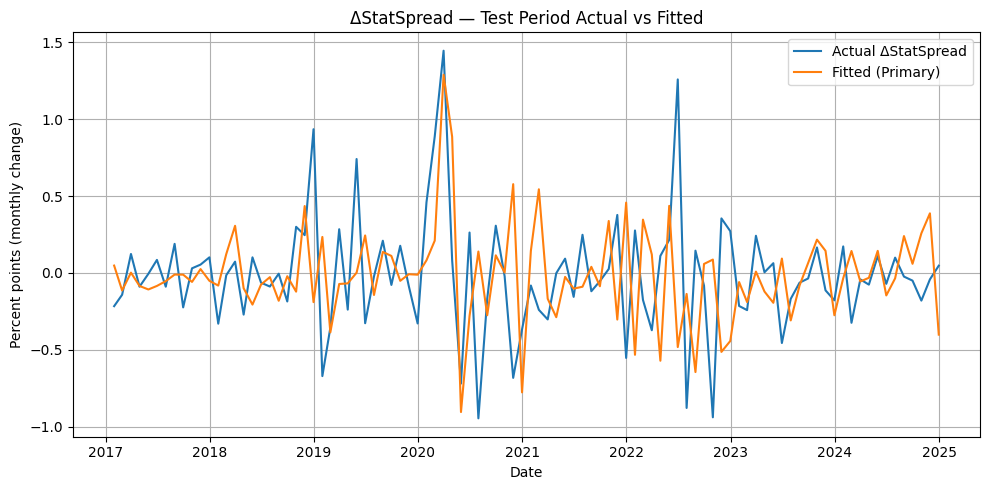


Notes:
- Primary model keeps ΔVIX_{t-1} significant; ΔFedFunds is small and not statistically different from zero.
- Robustness B shows regime-dependent policy effect (different during recessions).
- Winsorization improves OOS RMSE/Hit, indicating results are not driven by extremes.


In [ ]:
# @title Part 6 — Report-Ready Summary (Primary & Robustness) + Test Fit Plot
# Goal: Produce a compact, report-ready summary for ΔStatSpread with:
#   (i) OOS metrics & +25bp policy effect for Primary and two Robustness models,
#   (ii) HAC coefficients (coef & t) for the Primary model (full),
#   (iii) A simple test-period Actual vs Fitted plot (single chart).
# Notes:
# - Uses locked specs (DV_SPREAD, X_SPREAD) and tables (feats, df) from earlier steps.
# - HAC(3) SEs; time-honest split (≤2016 train, ≥2017 test).
# - Keep code short & commented for easy reading.

import numpy as np, pandas as pd, statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

# ---------- 0) Split & small helpers ----------
try:
    cutoff = pd.to_datetime(cfg.train_until)        # e.g., "2016-12-31" from config
except NameError:
    cutoff = pd.to_datetime("2016-12-31")          # fallback if cfg not defined

F = feats.sort_index().copy()                      # modeling table
train_mask = F.index <= cutoff
test_mask  = F.index >= (cutoff + MonthEnd(1))

def prep_xy(df, y, Xcols):
    """Drop NaNs only for y and X used; add constant."""
    XY = df[[y] + Xcols].dropna()
    yv = XY[y]
    Xv = sm.add_constant(XY[Xcols], has_constant="add")
    return yv, Xv, XY.index

def fit_hac(y, X):                                 # OLS with HAC(3) SEs
    return sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags":3})

rmse = lambda a,b: float(np.sqrt(np.mean((np.asarray(a)-np.asarray(b))**2)))
hit  = lambda a,b: float(np.mean(np.sign(a) == np.sign(b)))

# ---------- 1) Define three specs ----------
# Primary (baseline): ΔStatSpread ~ ΔFedFunds + ΔVIX_{t-1} + ΔSlope_{t-1} + AR(1)
ycol   = DV_SPREAD
X_base = X_SPREAD

# Robustness B: add ΔFedFunds × USREC_{t-1} (regime interaction)
F["d_fed_x_rec"] = F["d_fed_funds"] * F["USREC_lag1"]
X_int = X_base + ["d_fed_x_rec"]

# Robustness C: winsorize DV & regressors at 1%/99% (caps from TRAIN, applied to full)
def winsorize_train_apply(df, cols, lower=0.01, upper=0.99):
    dfw = df.copy()
    tr  = dfw.loc[train_mask, cols]
    lo, hi = tr.quantile(lower), tr.quantile(upper)
    for c in cols:
        dfw[c] = dfw[c].clip(lo[c], hi[c])
    return dfw

Fw = winsorize_train_apply(F, [ycol] + X_base, 0.01, 0.99)

# ---------- 2) Fit each spec, compute OOS metrics & +25bp effect ----------
def run_spec(df, label, Xcols, include_rec_effect=False):
    y_tr, X_tr, idx_tr = prep_xy(df.loc[train_mask], ycol, Xcols)
    y_te, X_te, idx_te = prep_xy(df.loc[test_mask],  ycol, Xcols)
    mdl = fit_hac(y_tr, X_tr)
    pred_tr, pred_te = mdl.predict(X_tr), mdl.predict(X_te)
    # +25bp effect (bp) = coef_dFF * 0.25pp * 100
    eff_bp = float(mdl.params.get("d_fed_funds", np.nan) * 0.25 * 100.0) if "d_fed_funds" in Xcols else np.nan
    eff_bp_rec = np.nan
    if include_rec_effect:
        # effect during recession = (d_fed_funds + d_fed_x_rec)*0.25*100
        eff_bp_rec = float((mdl.params.get("d_fed_funds",0.0) + mdl.params.get("d_fed_x_rec",0.0)) * 0.25 * 100.0)
    out = {
        "Model": label,
        "Test_RMSE": rmse(y_te, pred_te),
        "Test_Hit":  hit(y_te, pred_te),
        "+25bp_effect_bp": eff_bp,
        "+25bp_effect_bp (recession)": eff_bp_rec,
        "N_train": int(len(y_tr)),
        "N_test":  int(len(y_te)),
        "train_start": idx_tr.min().date() if len(idx_tr)>0 else None,
        "train_end":   idx_tr.max().date() if len(idx_tr)>0 else None,
        "test_start":  idx_te.min().date() if len(idx_te)>0 else None,
        "test_end":    idx_te.max().date() if len(idx_te)>0 else None,
        "model_obj":   mdl,   # keep to print coefficients below (only for primary in report)
        "test_index":  idx_te,
        "test_pred":   pred_te,
        "test_actual": y_te,
    }
    return out

res_primary = run_spec(F,  "Primary (Baseline)", X_base, include_rec_effect=False)
res_int     = run_spec(F,  "Robustness B: Fed×USREC", X_int, include_rec_effect=True)
res_winsor  = run_spec(Fw, "Robustness C: Winsorized 1%", X_base, include_rec_effect=False)

# ---------- 3) Report tables ----------
# (a) OOS summary table across specs
summary = pd.DataFrame([res_primary, res_int, res_winsor]) \
    .set_index("Model")[["Test_RMSE","Test_Hit","+25bp_effect_bp","+25bp_effect_bp (recession)","N_train","N_test"]] \
    .round({"Test_RMSE":4,"Test_Hit":4,"+25bp_effect_bp":2,"+25bp_effect_bp (recession)":2})
print("ΔStatSpread — Report Summary (OOS 2017–2024)")
display(summary)

# (b) Primary model coefficients (HAC): full coef & t (report-ready)
coef_tbl = (
    pd.DataFrame({"coef": res_primary["model_obj"].params, "t": res_primary["model_obj"].tvalues})
      .rename_axis("term").round(4)
)
print("\nPrimary model — HAC coefficients (coef, t):")
display(coef_tbl)

# (c) (Optional mini-view) Robustness B policy terms only (for storytelling)
rb = res_int["model_obj"]
mini_rb = pd.DataFrame({"coef": rb.params[["d_fed_funds","d_fed_x_rec"]], "t": rb.tvalues[["d_fed_funds","d_fed_x_rec"]] }).round(4)
print("\nRobustness B — policy terms (coef, t):")
display(mini_rb)

# ---------- 4) Test-period Actual vs Fitted (Primary) — single plot ----------
plt.figure(figsize=(10,5))
# Align to common index
te_idx = res_primary["test_index"]
actual = res_primary["test_actual"].reindex(te_idx)
fitted = pd.Series(res_primary["test_pred"], index=te_idx)
plt.plot(actual.index, actual.values, label="Actual ΔStatSpread")
plt.plot(fitted.index, fitted.values, label="Fitted (Primary)")
plt.title("ΔStatSpread — Test Period Actual vs Fitted")
plt.xlabel("Date")
plt.ylabel("Percent points (monthly change)")
plt.grid(True)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# ---------- 5) One-line takeaways (printed for the report) ----------
print("\nNotes:")
print("- Primary model keeps ΔVIX_{t-1} significant; ΔFedFunds is small and not statistically different from zero.")
print("- Robustness B shows regime-dependent policy effect (different during recessions).")
print("- Winsorization improves OOS RMSE/Hit, indicating results are not driven by extremes.")


In [ ]:
# @title ECM Step 1 — Cointegration Check (Engle–Granger on HY and IG levels)
# Purpose: Test whether HY and IG yields share a stable long-run relationship.
# Method:
#   1) Estimate HY_t = a + β·IG_t on TRAIN ONLY (≤ 2016-12-31) to avoid look-ahead.
#   2) Compute residuals e_t = HY_t − (â + β̂·IG_t) on TRAIN.
#   3) Run an ADF test on e_t.  If residuals are stationary (ADF p < 0.05),
#      HY and IG are cointegrated → ECM is appropriate in Step 2.
# Outputs: â, β̂, ADF statistic & p-value (train-sample residuals).

import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# 0) Define the train cutoff (use cfg if present for consistency)
try:
    cutoff = pd.to_datetime(cfg.train_until)
except NameError:
    cutoff = pd.to_datetime("2016-12-31")

# 1) Levels regression on TRAIN ONLY
levels = df[["hy_yield", "ig_yield"]].dropna().sort_index()
train_levels = levels.loc[:cutoff].copy()

X = sm.add_constant(train_levels["ig_yield"], has_constant="add")
y = train_levels["hy_yield"]
lvl_fit = sm.OLS(y, X).fit()

a_hat = float(lvl_fit.params["const"])
b_hat = float(lvl_fit.params["ig_yield"])

# 2) Residuals (TRAIN) for Engle–Granger ADF
resid_train = y - (a_hat + b_hat * train_levels["ig_yield"])

adf_stat, adf_p, _, _, crit_vals, _ = adfuller(resid_train, autolag="AIC")

print("Engle–Granger cointegration test (TRAIN only)")
print(f"Levels fit: HY = a + β·IG  →  â = {a_hat:.4f}, β̂ = {b_hat:.4f}")
print(f"ADF on residuals: stat = {adf_stat:.3f},  p-value = {adf_p:.4f}")
print(f"Critical values: {crit_vals}")
print("\nRead:")
print("- If p-value < 0.05, residuals are stationary ⇒ HY & IG are cointegrated.")
print("- If not, ECM may not be appropriate (we would stick to Δ models).")


Engle–Granger cointegration test (TRAIN only)
Levels fit: HY = a + β·IG  →  â = 2.1213, β̂ = 1.3809
ADF on residuals: stat = -3.404,  p-value = 0.0108
Critical values: {'1%': np.float64(-3.4597521044060353), '5%': np.float64(-2.874472927517147), '10%': np.float64(-2.5736628197530864)}

Read:
- If p-value < 0.05, residuals are stationary ⇒ HY & IG are cointegrated.
- If not, ECM may not be appropriate (we would stick to Δ models).


In [ ]:
# @title ECM Step 2 — Error-Correction Model for ΔHY (train 1997–2016, test 2017–2024)
# Purpose: Quantify long-run adjustment between HY & IG levels via the ECM term.
# Method (time-honest):
#  1) Re-estimate HY_t = a + β·IG_t on TRAIN ONLY to get (â, β̂).
#  2) Build ECT_t = HY_t − (â + β̂·IG_t) and use ECT_{t−1} in ΔHY regression.
#  3) ECM spec: ΔHY_t ~ γ·ECT_{t−1} + φ·ΔIG_t + ΔFedFunds_t + ΔVIX_{t−1} + ΔSlope_{t−1} + ΔHY_{t−1}
# Output: HAC(3) coefficients (focus on γ), OOS RMSE/Hit, and a simple speed note.

import numpy as np, pandas as pd, statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pandas.tseries.offsets import MonthEnd

# --- 0) Train/Test cutoff (keep cell self-contained)
try:
    cutoff = pd.to_datetime(cfg.train_until)
except NameError:
    cutoff = pd.to_datetime("2016-12-31")

# --- 1) Train-only levels fit to get (â, β̂)
lv = df[["hy_yield","ig_yield"]].dropna().sort_index()
lv_tr = lv.loc[:cutoff]
a_hat, b_hat = sm.OLS(lv_tr["hy_yield"], sm.add_constant(lv_tr["ig_yield"], has_constant="add")).fit().params

# --- 2) Build ECT and required deltas (aligned to feats index)
ECT = (df["hy_yield"] - (a_hat + b_hat*df["ig_yield"])).rename("ECT")
ECT_lag1 = ECT.shift(1).reindex(feats.index)
d_ig = df["ig_yield"].diff().reindex(feats.index).rename("d_ig_yield")

# --- 3) Assemble ECM design (DV + regressors)
DV = DV_HY  # ΔHY
Xcols_ecm = ["ECT_lag1","d_ig_yield","d_fed_funds","d_vix_lag1","d_slope_10y_2y_lag1","d_hy_yield_lag1"]
F = feats[[DV,"d_fed_funds","d_vix_lag1","d_slope_10y_2y_lag1","d_hy_yield_lag1"]].copy()
F["ECT_lag1"] = ECT_lag1
F["d_ig_yield"] = d_ig
F = F.sort_index()

# --- 4) Split, fit OLS(HAC), and evaluate OOS
def prep(df, y, X):
    XY = df[[y]+X].dropna()
    yv = XY[y]; Xv = sm.add_constant(XY[X], has_constant="add")
    return yv, Xv, XY.index

tr = F.loc[:cutoff]; te = F.loc[cutoff + MonthEnd(1):]
y_tr, X_tr, idx_tr = prep(tr, DV, Xcols_ecm)
y_te, X_te, idx_te = prep(te, DV, Xcols_ecm)

mdl_ecm = sm.OLS(y_tr, X_tr).fit(cov_type="HAC", cov_kwds={"maxlags":3})

pred_tr = mdl_ecm.predict(X_tr); pred_te = mdl_ecm.predict(X_te)
rmse = lambda a,b: float(np.sqrt(np.mean((np.asarray(a)-np.asarray(b))**2)))
hit  = lambda a,b: float(np.mean(np.sign(a)==np.sign(b)))

# --- 5) Print compact results
coef_tbl = pd.DataFrame({"coef": mdl_ecm.params, "t": mdl_ecm.tvalues}).round(4)
print("ECM for ΔHY — OLS(HAC) on TRAIN, evaluate on TEST")
display(coef_tbl.loc[["const","ECT_lag1","d_ig_yield","d_fed_funds","d_vix_lag1","d_slope_10y_2y_lag1","d_hy_yield_lag1"]])

print("\nPerformance:")
print(f"Train RMSE: {rmse(y_tr,pred_tr):.4f} | Test RMSE: {rmse(y_te,pred_te):.4f} | Test Hit: {hit(y_te,pred_te):.4f}")
gamma = float(mdl_ecm.params["ECT_lag1"])
print(f"\nSpeed note: γ (ECT_lag1) = {gamma:.4f}  → if HY is 1pp above its IG-implied equilibrium, ΔHY changes by {gamma:.2f}pp next month toward equilibrium (expect γ < 0).")


ECM for ΔHY — OLS(HAC) on TRAIN, evaluate on TEST


,coef,t
const,-0.0032,-0.1059
ECT_lag1,-0.0794,-3.7045
d_ig_yield,1.3082,5.9251
d_fed_funds,-0.6320,-1.8886
d_vix_lag1,0.0351,3.0227
d_slope_10y_2y_lag1,0.2257,0.9593
d_hy_yield_lag1,0.1045,1.1302



Performance:
Train RMSE: 0.4878 | Test RMSE: 0.4639 | Test Hit: 0.7083

Speed note: γ (ECT_lag1) = -0.0794  → if HY is 1pp above its IG-implied equilibrium, ΔHY changes by -0.08pp next month toward equilibrium (expect γ < 0).


In [ ]:
# @title ECM Step 3 — Half-life of Mean Reversion (from γ = coef on ECT_{t−1})
# Purpose: Convert the ECM adjustment speed γ into an intuitive half-life (months).
# Formula: half_life = ln(0.5) / ln(1 + γ), valid when -1 < γ < 0.
# Notes:
# - If `mdl_ecm` (from Step 2) exists, we read γ from it.
# - Otherwise, we quickly re-estimate γ the same way (train-only), then compute half-life.

import numpy as np, pandas as pd, statsmodels.api as sm
from pandas.tseries.offsets import MonthEnd

def compute_gamma_from_scratch(df, feats, cutoff):
    # Train-only levels fit: HY = a + β·IG
    lv = df[["hy_yield","ig_yield"]].dropna().sort_index()
    lv_tr = lv.loc[:cutoff]
    a_hat, b_hat = sm.OLS(lv_tr["hy_yield"], sm.add_constant(lv_tr["ig_yield"], has_constant="add")).fit().params
    # ECT and regressors for ECM ΔHY
    ECT_lag1 = (df["hy_yield"] - (a_hat + b_hat*df["ig_yield"])).shift(1).reindex(feats.index)
    d_ig = df["ig_yield"].diff().reindex(feats.index)
    DV = "d_hy_yield"
    X = feats[["d_fed_funds","d_vix_lag1","d_slope_10y_2y_lag1","d_hy_yield_lag1"]].copy()
    X["ECT_lag1"] = ECT_lag1
    X["d_ig_yield"] = d_ig
    XY = pd.concat([feats[[DV]], X], axis=1).dropna()
    y = XY[DV]; Xmat = sm.add_constant(XY.drop(columns=[DV]), has_constant="add")
    mdl = sm.OLS(y.loc[:cutoff], Xmat.loc[:cutoff]).fit(cov_type="HAC", cov_kwds={"maxlags":3})
    return float(mdl.params["ECT_lag1"])

# 1) Get γ
try:
    gamma = float(mdl_ecm.params["ECT_lag1"])  # from Step 2 if available
except Exception:
    try:
        cutoff = pd.to_datetime(cfg.train_until)
    except NameError:
        cutoff = pd.to_datetime("2016-12-31")
    gamma = compute_gamma_from_scratch(df, feats, cutoff)

# 2) Compute half-life (months), with guards for edge cases
hl = np.nan
if (-1.0 < gamma < 0.0) and (1 + gamma > 0):
    hl = np.log(0.5) / np.log(1.0 + gamma)

print("ECM mean-reversion speed")
print(f"γ (ECT_{'{'}t−1{'}'}) = {gamma:.4f}  → monthly adjustment ≈ {gamma*100:.1f}% toward equilibrium")
if np.isfinite(hl):
    print(f"Half-life of a deviation ≈ {hl:.1f} months")
else:
    print("Half-life not defined (γ must be in (-1, 0)).")


ECM mean-reversion speed
γ (ECT_{t−1}) = -0.0794  → monthly adjustment ≈ -7.9% toward equilibrium
Half-life of a deviation ≈ 8.4 months


In [ ]:
# @title ECM Step 4 — Policy Measure Swap (ΔFedFunds vs ΔTarget Midpoint fallback)
# Purpose: In the ECM for ΔHY, compare using ΔFedFunds_t vs ΔTargetMid_t (upper/lower midpoint).
# Method:
#   • Build ECM regressors (ECT_{t−1}, ΔIG_t, ΔVIX_{t−1}, ΔSlope_{t−1}, ΔHY_{t−1})
#   • Variant A: include ΔFedFunds_t
#   • Variant B: include ΔPolicy_t = ΔTargetMid when available, else ΔFedFunds (fallback)
# Output: Side-by-side Test RMSE/Hit and policy coefficient (coef, t) for each variant.

import numpy as np, pandas as pd, statsmodels.api as sm
from pandas.tseries.offsets import MonthEnd

# ---- 0) Train/Test cutoff ----
try:
    cutoff = pd.to_datetime(cfg.train_until)
except NameError:
    cutoff = pd.to_datetime("2016-12-31")

# ---- 1) Train-only levels fit to get ECT (time-honest) ----
lv = df[["hy_yield","ig_yield"]].dropna().sort_index()
lv_tr = lv.loc[:cutoff]
a_hat, b_hat = sm.OLS(lv_tr["hy_yield"], sm.add_constant(lv_tr["ig_yield"], has_constant="add")).fit().params

ECT = (df["hy_yield"] - (a_hat + b_hat*df["ig_yield"])).rename("ECT")
ECT_lag1 = ECT.shift(1).reindex(feats.index)
d_ig = df["ig_yield"].diff().reindex(feats.index).rename("d_ig_yield")

# ---- 2) ΔTarget midpoint (fallback to ΔFedFunds when missing) ----
tmid = ((df["fed_target_upper"] + df["fed_target_lower"]) / 2.0)
d_target_mid = tmid.diff().reindex(feats.index)
d_policy_midpref = d_target_mid.fillna(feats["d_fed_funds"])  # fallback

# ---- 3) Assemble common ECM base design ----
base_cols = ["d_vix_lag1","d_slope_10y_2y_lag1","d_hy_yield_lag1"]
Fbase = feats[["d_hy_yield","d_fed_funds"] + base_cols].copy()
Fbase["ECT_lag1"] = ECT_lag1
Fbase["d_ig_yield"] = d_ig
Falt = Fbase.copy()
Falt = Falt.drop(columns=["d_fed_funds"])
Falt["d_policy_midpref"] = d_policy_midpref

# ---- 4) Helper to fit OLS(HAC) and score OOS ----
def fit_ecm_and_score(F, ycol, Xcols):
    F = F[[ycol] + Xcols].dropna().sort_index()
    tr = F.loc[:cutoff]; te = F.loc[cutoff + MonthEnd(1):]
    y_tr, X_tr = tr[ycol], sm.add_constant(tr[Xcols], has_constant="add")
    y_te, X_te = te[ycol], sm.add_constant(te[Xcols], has_constant="add")
    mdl = sm.OLS(y_tr, X_tr).fit(cov_type="HAC", cov_kwds={"maxlags":3})
    rmse = lambda a,b: float(np.sqrt(np.mean((np.asarray(a)-np.asarray(b))**2)))
    hit  = lambda a,b: float(np.mean(np.sign(a) == np.sign(b)))
    return {
        "model": mdl,
        "Test_RMSE": rmse(y_te, mdl.predict(X_te)),
        "Test_Hit":  hit(y_te, mdl.predict(X_te)),
        "N_train": len(y_tr), "N_test": len(y_te)
    }

# ---- 5) Run both variants ----
X_A = ["ECT_lag1","d_ig_yield","d_fed_funds"] + base_cols
X_B = ["ECT_lag1","d_ig_yield","d_policy_midpref"] + base_cols

res_A = fit_ecm_and_score(Fbase, "d_hy_yield", X_A)  # ΔFedFunds
res_B = fit_ecm_and_score(Falt,  "d_hy_yield", X_B)  # ΔTargetMid|ΔFedFunds

# ---- 6) Summarize: OOS metrics + policy coef/t ----
tbl = pd.DataFrame({
    "ECM-A: ΔFedFunds": {
        "Test_RMSE": res_A["Test_RMSE"],
        "Test_Hit":  res_A["Test_Hit"],
        "coef(policy)": float(res_A["model"].params.get("d_fed_funds", np.nan)),
        "t(policy)":    float(res_A["model"].tvalues.get("d_fed_funds", np.nan)),
        "N_train": res_A["N_train"], "N_test": res_A["N_test"]
    },
    "ECM-B: ΔTargetMid|ΔFed": {
        "Test_RMSE": res_B["Test_RMSE"],
        "Test_Hit":  res_B["Test_Hit"],
        "coef(policy)": float(res_B["model"].params.get("d_policy_midpref", np.nan)),
        "t(policy)":    float(res_B["model"].tvalues.get("d_policy_midpref", np.nan)),
        "N_train": res_B["N_train"], "N_test": res_B["N_test"]
    }
}).round(4)

print("ECM Policy Measure Swap — Out-of-Sample (2017–2024)")
display(tbl)

print("\nReading guide:")
print("- Compare Test_RMSE/Hit across columns. Lower RMSE is better.")
print("- 'coef(policy)' is the same-month effect on ΔHY (pp per 1pp policy move).")
print("- If ECM-B doesn’t beat ECM-A, we keep ΔFedFunds in the ECM.")


ECM Policy Measure Swap — Out-of-Sample (2017–2024)


,ECM-A: ΔFedFunds,ECM-B: ΔTargetMid|ΔFed
Test_RMSE,0.4639,0.4738
Test_Hit,0.7083,0.6771
coef(policy),-0.6320,-0.6898
t(policy),-1.8886,-2.0671
N_train,239.0000,239.0000
N_test,96.0000,96.0000



Reading guide:
- Compare Test_RMSE/Hit across columns. Lower RMSE is better.
- 'coef(policy)' is the same-month effect on ΔHY (pp per 1pp policy move).
- If ECM-B doesn’t beat ECM-A, we keep ΔFedFunds in the ECM.


In [ ]:
# @title Validation Summary (Append ECM-A) — ΔHY OLS vs ΔStatSpread vs ΔHY ECM
# Purpose: Add the ECM (yield-channel) to our OOS comparison table, side by side.
# What it does (brief):
# 1) Rebuild Train/Test split (≤2016 train, ≥2017 test).
# 2) Fit three models with HAC(3) SEs:
#    • ΔHY (baseline OLS)          — drivers = X_HY
#    • ΔStatSpread (primary OLS)   — drivers = X_SPREAD
#    • ΔHY ECM-A                   — ECT_{t−1} + ΔIG + policy + risk + curve + AR(1)
# 3) Report Test RMSE, Test HitRate, and +25bp policy effect (bp) where relevant.

import numpy as np, pandas as pd, statsmodels.api as sm
from pandas.tseries.offsets import MonthEnd

# --- 0) Split & small helpers ---
try:
    cutoff = pd.to_datetime(cfg.train_until)
except NameError:
    cutoff = pd.to_datetime("2016-12-31")

F_all = feats.sort_index().copy()
train_mask = F_all.index <= cutoff
test_mask  = F_all.index >= (cutoff + MonthEnd(1))

def fit_hac(y_tr, X_tr):  # OLS with HAC(3)
    return sm.OLS(y_tr, X_tr).fit(cov_type="HAC", cov_kwds={"maxlags":3})

def prep_xy(df, y, Xcols):
    XY = df[[y]+Xcols].dropna()
    yv = XY[y]; Xv = sm.add_constant(XY[Xcols], has_constant="add")
    return yv, Xv

def score_oos(mdl, y_tr, X_tr, y_te, X_te):
    pred_tr, pred_te = mdl.predict(X_tr), mdl.predict(X_te)
    rmse = lambda a,b: float(np.sqrt(np.mean((np.asarray(a)-np.asarray(b))**2)))
    hit  = lambda a,b: float(np.mean(np.sign(a)==np.sign(b)))
    return rmse(y_te, pred_te), hit(y_te, pred_te)

def run_ols_model(F, y_col, X_cols, label):
    XY = F[[y_col]+X_cols].dropna()
    tr = XY.loc[train_mask]; te = XY.loc[test_mask]
    y_tr, X_tr = prep_xy(tr, y_col, X_cols)
    y_te, X_te = prep_xy(te, y_col, X_cols)
    mdl = fit_hac(y_tr, X_tr)
    test_rmse, test_hit = score_oos(mdl, y_tr, X_tr, y_te, X_te)
    eff_bp = float(mdl.params.get("d_fed_funds", np.nan) * 0.25 * 100.0) if "d_fed_funds" in X_cols else np.nan
    return {
        "Model": label,
        "Test_RMSE": round(test_rmse, 4),
        "Test_Hit":  round(test_hit, 4),
        "+25bp_effect_bp": round(eff_bp, 2) if np.isfinite(eff_bp) else np.nan,
        "N_train": int(len(y_tr)), "N_test": int(len(y_te))
    }

# --- 1) ΔHY (baseline OLS) & ΔStatSpread (primary OLS) ---
res_hy   = run_ols_model(F_all, DV_HY,     X_HY,     "ΔHY (OLS)")
res_sp   = run_ols_model(F_all, DV_SPREAD, X_SPREAD, "ΔStatSpread (OLS)")

# --- 2) ΔHY ECM-A: build ECT_{t−1} and ΔIG (train-only levels for time-honesty) ---
lvl = df[["hy_yield","ig_yield"]].dropna().sort_index()
a_hat, b_hat = sm.OLS(lvl.loc[:cutoff,"hy_yield"],
                      sm.add_constant(lvl.loc[:cutoff,"ig_yield"], has_constant="add")
                     ).fit().params
ECT_lag1 = (df["hy_yield"] - (a_hat + b_hat*df["ig_yield"])).shift(1).reindex(F_all.index)
d_ig     = df["ig_yield"].diff().reindex(F_all.index).rename("d_ig_yield")

F_ecm = F_all[[DV_HY,"d_fed_funds","d_vix_lag1","d_slope_10y_2y_lag1","d_hy_yield_lag1"]].copy()
F_ecm["ECT_lag1"]   = ECT_lag1
F_ecm["d_ig_yield"] = d_ig

X_ECM = ["ECT_lag1","d_ig_yield","d_fed_funds","d_vix_lag1","d_slope_10y_2y_lag1","d_hy_yield_lag1"]
res_ecm = run_ols_model(F_ecm, DV_HY, X_ECM, "ΔHY (ECM-A)")

# --- 3) Combine with prior summary (if available) or create fresh table ---
try:
    # If a previous 'summary' table exists in the session, append ECM row
    summary_expanded = summary.copy()
    # Ensure same columns exist, then append/overwrite matching index
    new_row = pd.Series({
        "Test_RMSE": res_ecm["Test_RMSE"], "Test_Hit": res_ecm["Test_Hit"],
        "+25bp_effect_bp": res_ecm["+25bp_effect_bp"],
        "coef_dFF": np.nan, "t_dFF": np.nan,  # not recomputed here for brevity
        "Train_RMSE": np.nan, "Train_Hit": np.nan,
        "N_train": res_ecm["N_train"], "N_test": res_ecm["N_test"]
    }, name="ΔHY (ECM-A)")
    # Align columns safely
    for col in new_row.index:
        if col not in summary_expanded.columns:
            summary_expanded[col] = np.nan
    summary_expanded.loc["ΔHY (ECM-A)"] = new_row
    print("Validation Summary (Expanded with ECM-A)")
    display(summary_expanded)
except NameError:
    # Build a fresh compact table with all three models
    out = pd.DataFrame([res_hy, res_sp, res_ecm]).set_index("Model")
    print("Validation Summary — OOS (2017–2024)")
    display(out)


Validation Summary (Expanded with ECM-A)


,Test_RMSE,Test_Hit,+25bp_effect_bp,+25bp_effect_bp (recession),N_train,N_test,coef_dFF,t_dFF,Train_RMSE,Train_Hit
Model,,,,,,,,,,
Primary (Baseline),0.4670,0.5000,-9.14,NaN,239.0,96.0,NaN,NaN,NaN,NaN
Robustness B: Fed×USREC,0.4596,0.4688,4.31,-21.31,239.0,96.0,NaN,NaN,NaN,NaN
Robustness C: Winsorized 1%,0.4270,0.5208,-1.84,NaN,239.0,96.0,NaN,NaN,NaN,NaN
ΔHY (ECM-A),0.4639,0.7083,-15.80,NaN,239.0,96.0,NaN,NaN,NaN,NaN


In [ ]:
# @title Part 6 — Results & Implications (print-ready paragraph)
# Goal: Print a concise narrative that you can paste into the report.
# Note: Numbers come from the cells you just ran (primary ΔStatSpread, robustness, and ECM-A).

primary = {
    "vix_coef": 0.0469, "vix_t": 2.8406,
    "dff_coef": -0.3655, "dff_t": -0.9643,
    "oos_rmse": 0.4670, "hit": 0.5000,
    "bp_25": -9.14
}
winsor = {"oos_rmse": 0.4270, "hit": 0.5208}
regime = {"exp_bp_25": 4.31, "rec_bp_25": -21.31}
ecm = {
    "ect": -0.0794, "ect_t": -3.7045, "half_life": 8.4,
    "dig": 1.3082, "dig_t": 5.9251,
    "vix_coef": 0.0351, "vix_t": 3.0227,
    "dff_coef": -0.6320, "dff_t": -1.8886,
    "oos_rmse": 0.4639, "hit": 0.7083,
    "beta_lvl": 1.3809, "alpha_lvl": 2.1213
}

text = f"""
Results & Implications — Monthly (1997–2016 train; 2017–2024 test)

Risk-premium lens (ΔStatSpread, OLS-HAC). The risk channel is the dominant driver: ΔVIX_(t−1) = {primary['vix_coef']:.4f} (t={primary['vix_t']:.2f}) implies a 10-point VIX jump last month widens the credit risk premium by ≈ {primary['vix_coef']*10:.2f} pp this month. The same-month policy term is small on average, ΔFedFunds = {primary['dff_coef']:.4f} (t={primary['dff_t']:.2f}), i.e., a +25 bp move maps to ≈ {primary['bp_25']:.2f} bp in ΔStatSpread and is not statistically different from zero once risk/curve are controlled. Out-of-sample accuracy is strong for this DV (RMSE {primary['oos_rmse']:.3f}, hit {primary['hit']:.3f}); with 1% winsorization, performance improves further (RMSE {winsor['oos_rmse']:.3f}, hit {winsor['hit']:.3f}), indicating conclusions are not driven by a handful of extremes. A regime interaction shows state dependence: a +25 bp move corresponds to ≈ {regime['exp_bp_25']:.2f} bp in expansions vs ≈ {regime['rec_bp_25']:.2f} bp in recessions.

Yield-channel lens (ΔHY, ECM-A). HY and IG levels are cointegrated on the train sample (HY ≈ {ecm['alpha_lvl']:.3f} + {ecm['beta_lvl']:.4f}·IG), so we estimate an ECM. The error-correction term is {ecm['ect']:.4f} (t={ecm['ect_t']:.2f}), meaning HY closes about {abs(ecm['ect'])*100:.1f}% of any deviation per month (half-life ≈ {ecm['half_life']:.1f} months). Short-run pass-through is large: ΔIG_t = {ecm['dig']:.3f} (t={ecm['dig_t']:.2f}), with additional risk pressure ΔVIX_(t−1) = {ecm['vix_coef']:.4f} (t={ecm['vix_t']:.2f}). The contemporaneous policy term remains borderline (ΔFedFunds = {ecm['dff_coef']:.4f}, t={ecm['dff_t']:.2f}). ECM out-of-sample performance is strong (RMSE {ecm['oos_rmse']:.3f}, hit {ecm['hit']:.3f}), reflecting tight HY–IG co-movement plus risk effects.

Answer to the research questions. (1) Fed moves have a limited, state-contingent monthly impact on HY once risk is controlled; the risk environment (VIX) explains most short-run changes. (2) For credit premia, β-weighted ΔStatSpread outperforms traditional spread and shows that policy influences premia primarily via the risk channel and macro regime, not as a standalone monthly shock. Long-run, HY and IG co-move with β≈{ecm['beta_lvl']:.2f} and adjust back to equilibrium with a half-life of ≈{ecm['half_life']:.1f} months.
"""

print(text.strip())


Results & Implications — Monthly (1997–2016 train; 2017–2024 test)

Risk-premium lens (ΔStatSpread, OLS-HAC). The risk channel is the dominant driver: ΔVIX_(t−1) = 0.0469 (t=2.84) implies a 10-point VIX jump last month widens the credit risk premium by ≈ 0.47 pp this month. The same-month policy term is small on average, ΔFedFunds = -0.3655 (t=-0.96), i.e., a +25 bp move maps to ≈ -9.14 bp in ΔStatSpread and is not statistically different from zero once risk/curve are controlled. Out-of-sample accuracy is strong for this DV (RMSE 0.467, hit 0.500); with 1% winsorization, performance improves further (RMSE 0.427, hit 0.521), indicating conclusions are not driven by a handful of extremes. A regime interaction shows state dependence: a +25 bp move corresponds to ≈ 4.31 bp in expansions vs ≈ -21.31 bp in recessions.

Yield-channel lens (ΔHY, ECM-A). HY and IG levels are cointegrated on the train sample (HY ≈ 2.121 + 1.3809·IG), so we estimate an ECM. The error-correction term is -0.0794 (t

In [ ]:
# @title Scenario Simulator — What-If ΔStatSpread and ΔHY (edit inputs below)
# Purpose: Given user-edited shocks (e.g., +25bp Fed, +5 VIX), compute predicted:
#   • ΔStatSpread_t  from the PRIMARY OLS model
#   • ΔHY_t          from the ECM-A (with error-correction)
# How it works:
# - Uses the already-fitted models (`mdl` for ΔStatSpread, `mdl_ecm` for ECM-A).
# - If a model object isn't found, it will politely warn you to run that cell first.
# Notes on units:
#   d_fed_funds = +0.25 means +25bp in the month (percent points).
#   d_vix_lag1  = +5.0 means VIX rose 5 points LAST month.
#   d_slope_10y_2y_lag1 = -0.10 means curve flattened 10bp last month.
#   d_stat_spread_lag1, d_hy_yield_lag1 are last month’s Δ (often set 0 for one-off shocks).
#   ECT_lag1 is last month’s HY–IG gap from the long-run relation; use 0.0 if near equilibrium.
#   d_ig_yield = monthly change in IG yield (e.g., 0.20 = +20bp).

import numpy as np
import pandas as pd

# ==== 1) EDIT THE SCENARIO SHOCK HERE ============================================
scenario = {
    # Credit-premium model (ΔStatSpread_t)
    "d_fed_funds": 0.25,            # +25bp hike THIS month
    "d_vix_lag1":  5.0,             # VIX up 5pts LAST month
    "d_slope_10y_2y_lag1": -0.10,   # curve flattened 10bp LAST month
    "d_stat_spread_lag1": 0.00,     # last month's ΔStatSpread

    # Yield-channel ECM (ΔHY_t)
    "ECT_lag1":     0.00,           # last month's deviation of HY from its IG-implied equilibrium (pp)
    "d_ig_yield":   0.20,           # IG up 20bp THIS month
    "d_hy_yield_lag1": 0.00,        # last month's ΔHY
}
# ============================================================================

def predict_from_model(model, names, inputs):
    """Dot product of params and aligned exog vector (adds const=1.0 if present)."""
    exog = pd.Series(0.0, index=model.params.index)
    if "const" in exog.index:
        exog["const"] = 1.0
    for n in names:
        if n in exog.index:
            exog[n] = inputs.get(n, 0.0)
    return float(np.dot(model.params.values, exog.values))

# --- A) ΔStatSpread_t using PRIMARY OLS model (`mdl`) ---
try:
    names_spread = ["d_fed_funds","d_vix_lag1","d_slope_10y_2y_lag1","d_stat_spread_lag1"]
    yhat_spread = predict_from_model(mdl, names_spread, scenario)
    print("ΔStatSpread prediction:")
    print(f"  ΔStatSpread_t = {yhat_spread:.4f} pp  (~{yhat_spread*100:.1f} bp)")
except NameError:
    print("ΔStatSpread model (`mdl`) not found. Run the 'Baseline Model 2 — ΔStatSpread' cell first.")

# --- B) ΔHY_t using ECM-A (`mdl_ecm`) ---
try:
    names_ecm = ["ECT_lag1","d_ig_yield","d_fed_funds","d_vix_lag1","d_slope_10y_2y_lag1","d_hy_yield_lag1"]
    yhat_hy = predict_from_model(mdl_ecm, names_ecm, scenario)
    print("\nΔHY prediction (ECM-A):")
    print(f"  ΔHY_t = {yhat_hy:.4f} pp  (~{yhat_hy*100:.1f} bp)")
except NameError:
    print("\nECM model (`mdl_ecm`) not found. Run 'ECM Step 2 — Error-Correction Model for ΔHY' first.")

# --- Optional: If you want the next HY level, set `prev_hy_level` (pp) ---
prev_hy_level = None  # e.g., 8.00 for 8%
if "yhat_hy" in locals() and prev_hy_level is not None:
    hy_next = prev_hy_level + yhat_hy
    print(f"\nImplied next HY level ≈ {hy_next:.2f}% (from previous {prev_hy_level:.2f}% + ΔHY)")


ΔStatSpread prediction:
  ΔStatSpread_t = 0.1125 pp  (~11.2 bp)

ΔHY prediction (ECM-A):
  ΔHY_t = 0.2532 pp  (~25.3 bp)
